In [1]:
# global configs
FIGURE_DPI = 300
YEAR, EVALUATION = 2018, 2

In [2]:
from IPython.core.display import display, HTML
display(HTML(f'<h1>ANÁLISIS DE LA {EVALUATION}ª EVALUACIÓN</h1>'))
display(HTML(f'<h2>IES Puerto de la Cruz - Telesforo Bravo | Curso {YEAR}-{YEAR + 1}</h2>'))

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.core.display import display, HTML
import os

Estilo propio para los dataframes:

In [4]:
with open('../custom.css') as f:
    css_rules = ''.join(f.readlines())
HTML('<style>' + css_rules + '</style>')

Deshabilitar el *auto-scrolling* en todo el notebook:

In [5]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## CARGA DE DATOS

In [7]:
df = pd.DataFrame()
labels = []
for y in range(YEAR - 2, YEAR + 1):
    year_label = "C" + str(y)[2:] + str(y + 1)[2:]
    path = os.path.join("../data", year_label + ".xlsx")
    if y == YEAR:
        num_evaluations = EVALUATION
    else:
        num_evaluations = 3
    for ev in range(1, num_evaluations + 1):
        evaluation_label = f"E{ev}"
        data = pd.read_excel(path, sheet_name=evaluation_label)
        data["curso"] = year_label
        data["evaluación"] = evaluation_label
        data["absentismo"] = data["absentismo_justificado"] + data["absentismo_injustificado"]
        data["éxito_abs"] = round(data["ratio"] * (data["éxito"] / 100))
        data.set_index(["curso", "evaluación", "grupo"], inplace=True)
        df = df.append(data)
        labels.append((year_label, evaluation_label))
df.fillna(0, inplace=True)

In [8]:
df.head()

etapa  éxito  absentismo_justificado  \
curso evaluación grupo                                        
C1617 E1         ESO1A   ESO   41.7                    0.87   
                 ESO1B   ESO   46.2                    2.82   
                 ESO1C   ESO   28.0                    4.51   
                 ESO1D   ESO   46.2                    1.03   
                 ESO2A   ESO   46.2                    1.45   

                        absentismo_injustificado  partes  \
curso evaluación grupo                                     
C1617 E1         ESO1A                      6.08     4.0   
                 ESO1B                      2.63     3.0   
                 ESO1C                      7.12     2.0   
                 ESO1D                      3.66     3.0   
                 ESO2A                      2.87     2.0   

                        suspensión_asistencia  ratio  absentismo  éxito_abs  
curso evaluación grupo                                                       
C1617 E1         ESO1A                    0.0     24        6.95       10.0  
                 ESO1B                    0.0     26        5.45       12.0  
                 ESO1C                    1.0     25       11.63        7.0  
                 ESO1D                    0.0     26        4.69       12.0  
                 ESO2A                    0.0     26        4.32       12.0

In [9]:
# dataframe for current year and evaluation
dfc = df.loc[labels[-1]]

In [10]:
# dataframe for comparisons with last evaluation
df_comp = dfc.merge(df.loc[labels[-2]], left_index=True, right_index=True)

In [11]:
def get_data_by_stages(df, stages):
    if not isinstance(stages, list):
        stages = [stages]
    return df[df["etapa"].isin(stages)]

In [12]:
def makeup_chart(fontsize, value_margin, is_percentage, show_integer):
    if is_percentage:
        percentage_symbol = "%"
    else:
        percentage_symbol = ""
    plt.xlabel("")
    plt.ylabel("")
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize * 0.75)
    ax = plt.gca()
    if show_integer:
        annotation = "{:.0f}{}"
    else:
        annotation = "{:.2f}{}"
    # show values in bars
    for p in ax.patches:
        ax.annotate(
            annotation.format(p.get_height(), percentage_symbol),
            (p.get_x() + p.get_width() / 2., p.get_height() - value_margin),
            ha="center", va="center", fontsize=fontsize, color="white"
        )
    # hide chart frame
    for spine in ax.spines.values():
        spine.set_visible(False)

In [13]:
def bar_chart(serie, is_percentage=True, show_integer=True):
    FONTSIZE = 25
    serie = serie.sort_values()
    plt.figure(figsize=(30, 10), dpi=FIGURE_DPI)
    sns.barplot(serie.index, serie)
    makeup_chart(FONTSIZE, serie.max() / 20, is_percentage, show_integer)

In [14]:
def factor_chart(data, y, value_margin=2, is_percentage=True, estimator=np.mean, show_integer=True):
    FONTSIZE = 14
    plt.figure(figsize=(30, 10), dpi=FIGURE_DPI)
    colors = ["orange red", "windows blue", "amber"]
    custom_palette = sns.xkcd_palette(colors)
    sns.catplot(x="etapa", y=y, hue="curso", height=7, aspect=2, legend=False,
                   estimator=estimator, data=data.reset_index(), kind="bar",
                   palette=custom_palette, ci=None)
    plt.legend(loc="best", prop={"size": FONTSIZE}, frameon=True, framealpha=0.9)
    makeup_chart(FONTSIZE, value_margin, is_percentage, show_integer)

In [15]:
def color_gradient(serie, palette_name, inverse=False):
    unique_values = np.sort(serie.unique())
    if inverse:
        unique_values = unique_values[::-1]
    pal = sns.color_palette(palette_name, unique_values.size)
    cmap = {v: c for v, c in zip(unique_values, pal)}
    return np.array(serie.map(lambda x: cmap[x]))

In [16]:
CONFIG = (
    {"color": "Greens", "verb": "mejorado"},
    {"color": "Reds_r", "verb": "empeorado"}
)

def delta_chart(*args, label, inverse=False):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    for ix, ax in enumerate(axes):
        serie = args[ix]["delta"]
        if len(serie) == 0:
            continue
        pal = sns.color_palette(CONFIG[ix]["color"], len(serie))
        rank = serie.argsort().argsort()
        g = sns.barplot(serie.index, serie, ax=axes[ix],
                        palette=color_gradient(
                            serie,
                            CONFIG[ix]["color"], inverse))
        ax.set_axisbelow(True)
        ax.yaxis.grid(color="gray", linestyle="-", alpha=0.5)
        verb = CONFIG[ix]["verb"]
        title = f"Grupos que han {verb} en {label}"
        ax.set_title(title)

In [17]:
def stacked_chart(data, y, x1, x2, x1_label=None, x2_label=None):
    f, ax = plt.subplots(figsize=(6, 15))

    sns.set(style="whitegrid")
    
    sns.set_color_codes("pastel")
    if not x1_label:
        x1_label = x1
    sns.barplot(x=x1, y=y, data=data, label=x1_label, color="b")

    sns.set_color_codes("muted")
    if not x2_label:
        x2_label = x2
    sns.barplot(x=x2, y=y, data=data, label=x2_label, color="b")

    ax.legend(ncol=1, loc='upper right', frameon=True)
    ax.set(ylabel="", xlabel="")
    sns.despine(left=True, bottom=True)

# ÉXITO ESCOLAR

<div class="alert alert-success" role="alert">
    ÉXITO ESCOLAR = <b>0 suspensos</b>
</div>

## ÉXITO EN VALORES ABSOLUTOS

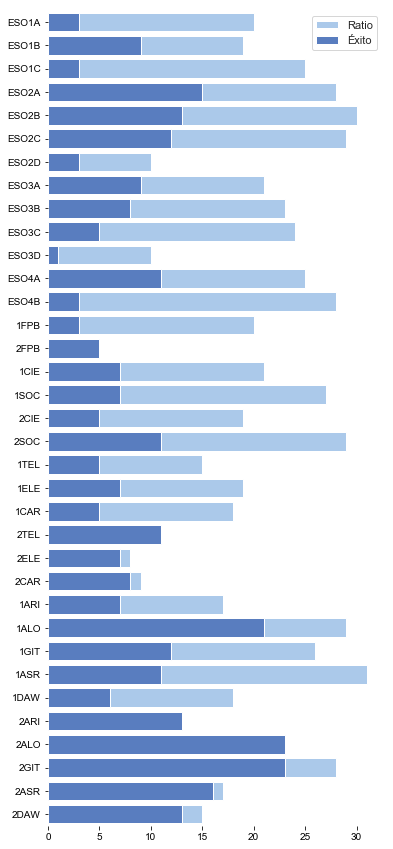

In [18]:
stacked_chart(dfc.reset_index(), "grupo", "ratio",
              "éxito_abs", "Ratio", "Éxito")

## ESO + FPB

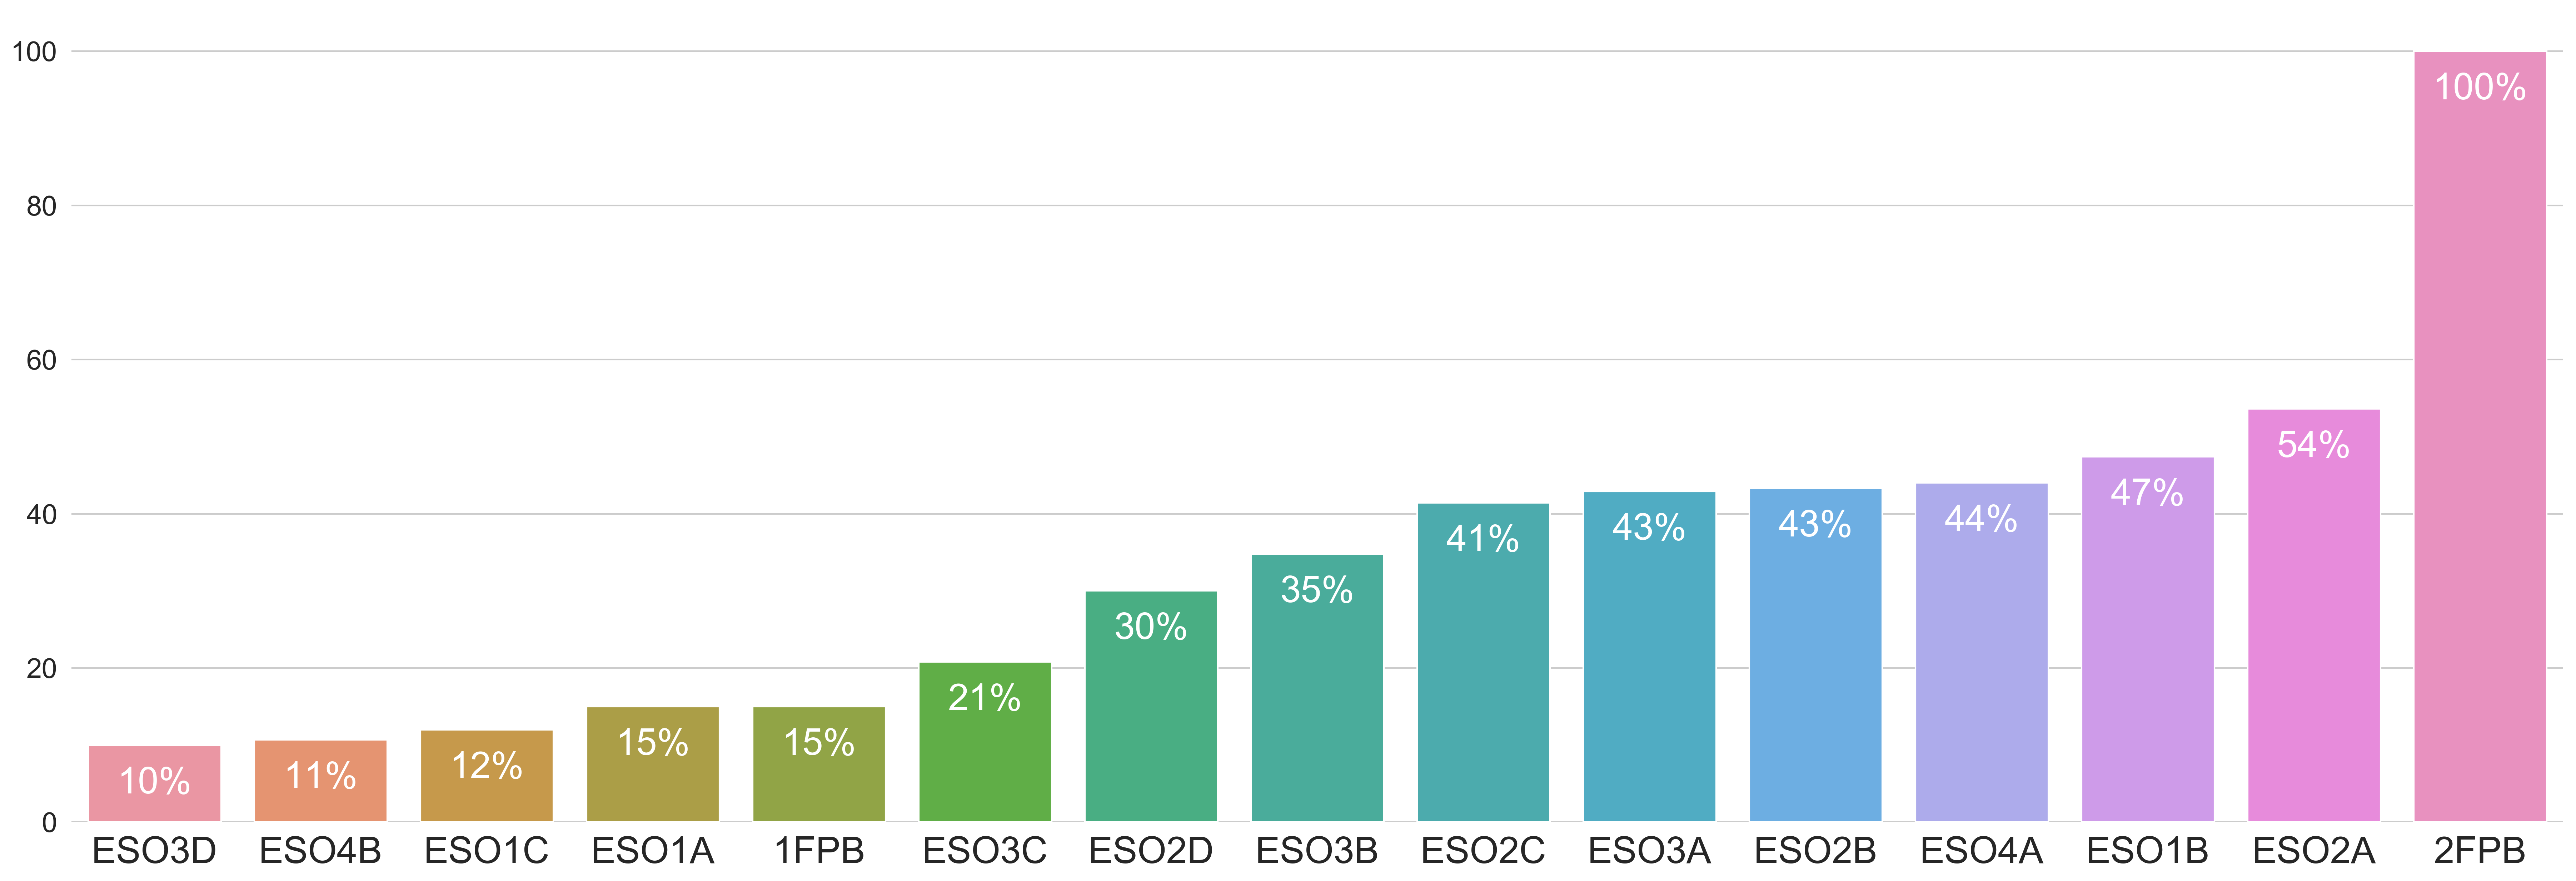

In [19]:
df_ESOFPB = get_data_by_stages(dfc, ["ESO", "FPB"])
bar_chart(df_ESOFPB["éxito"])

In [20]:
df_ESOFPB.mean()

éxito                       34.726667
absentismo_justificado       3.054667
absentismo_injustificado     7.215333
partes                       1.466667
suspensión_asistencia        0.733333
ratio                       21.133333
absentismo                  10.270000
éxito_abs                    6.866667
dtype: float64

## BACHILLERATO

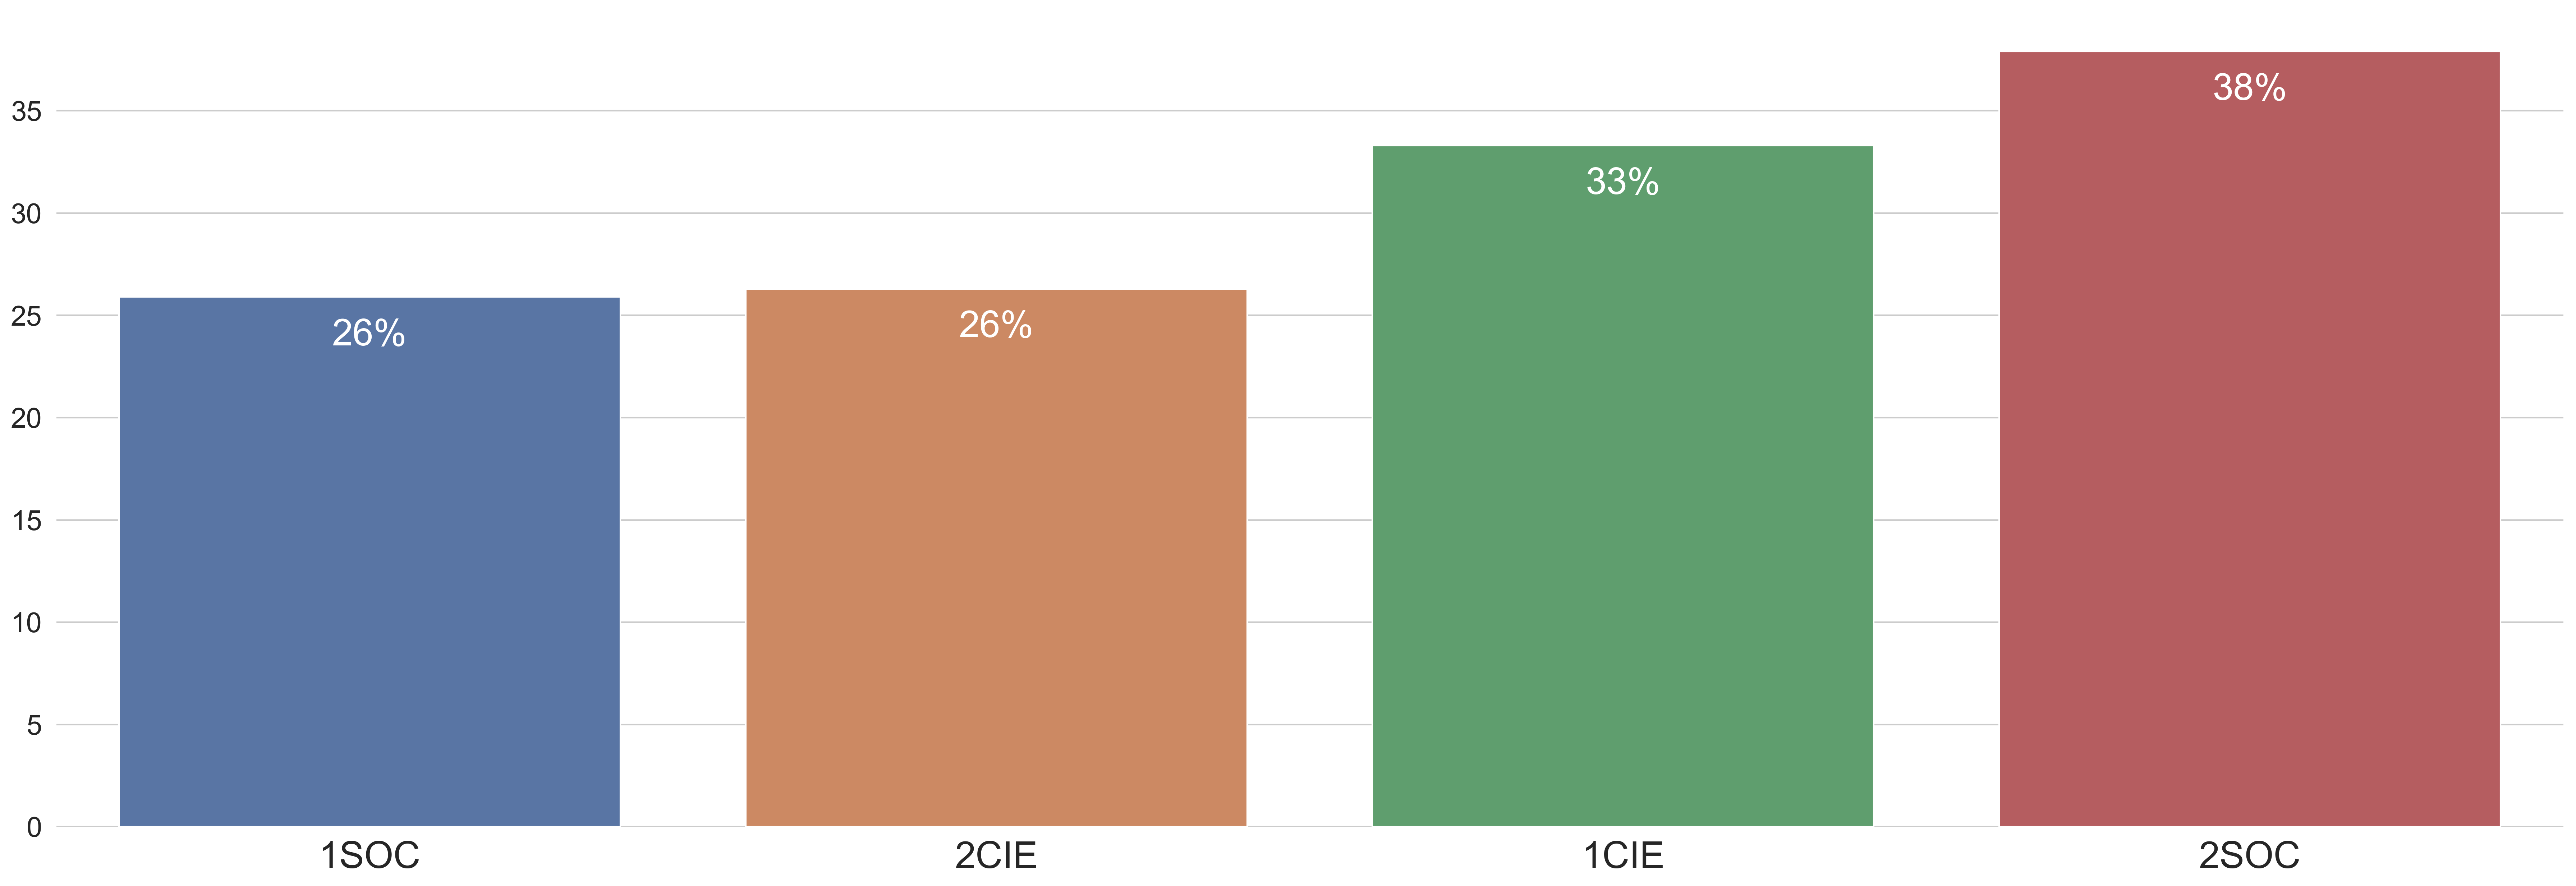

In [21]:
df_BACH = get_data_by_stages(dfc, "BACH")
bar_chart(df_BACH["éxito"])

In [22]:
df_BACH.mean()

éxito                       30.850
absentismo_justificado       3.370
absentismo_injustificado     3.125
partes                       0.000
suspensión_asistencia        0.000
ratio                       24.000
absentismo                   6.495
éxito_abs                    7.500
dtype: float64

## CICLOS FORMATIVOS DE GRADO MEDIO

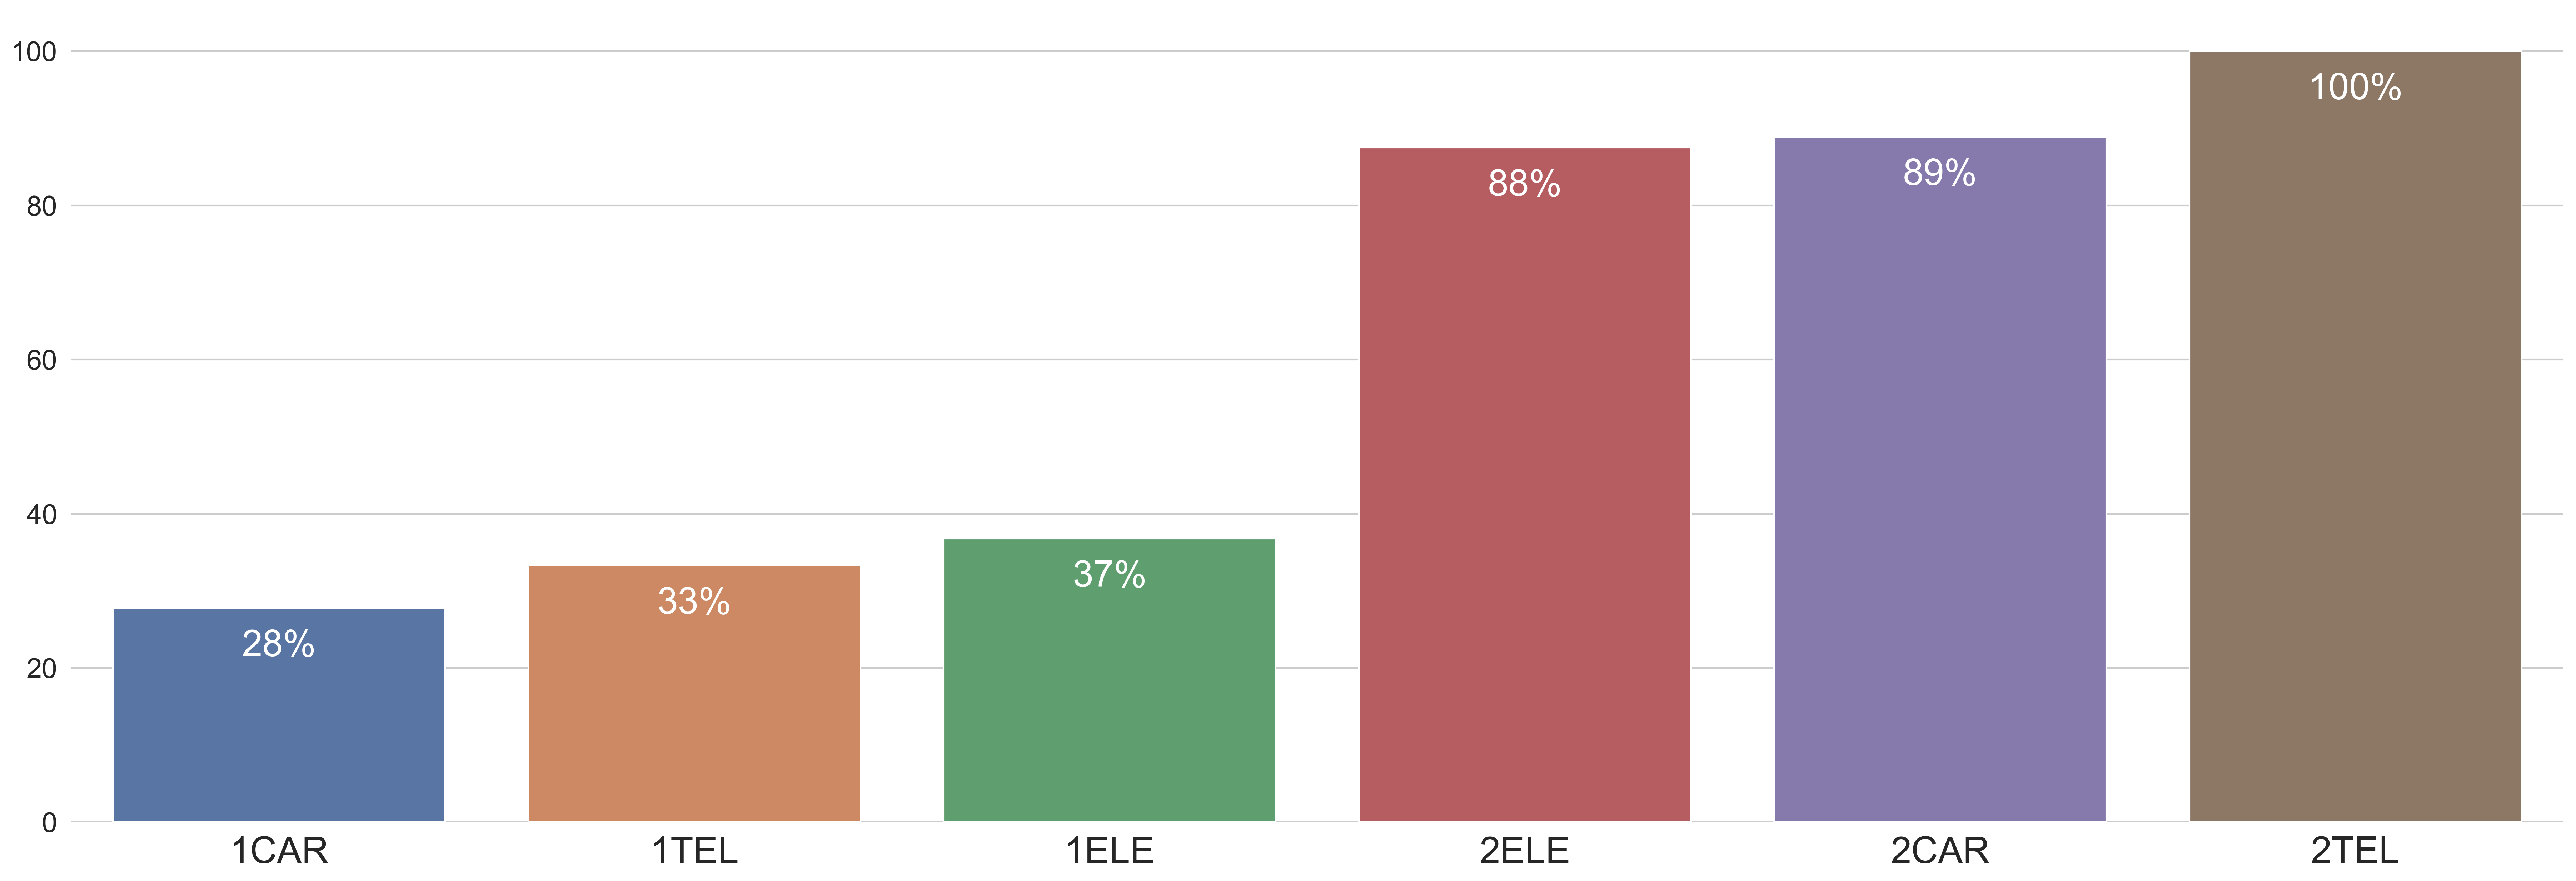

In [23]:
df_CFGM = get_data_by_stages(dfc, "CFGM")
bar_chart(df_CFGM["éxito"])

In [24]:
df_CFGM.mean()

éxito                       62.383333
absentismo_justificado       2.661667
absentismo_injustificado    12.836667
partes                       0.000000
suspensión_asistencia        0.000000
ratio                       13.333333
absentismo                  15.498333
éxito_abs                    7.166667
dtype: float64

## CICLOS FORMATIVOS DE GRADO SUPERIOR

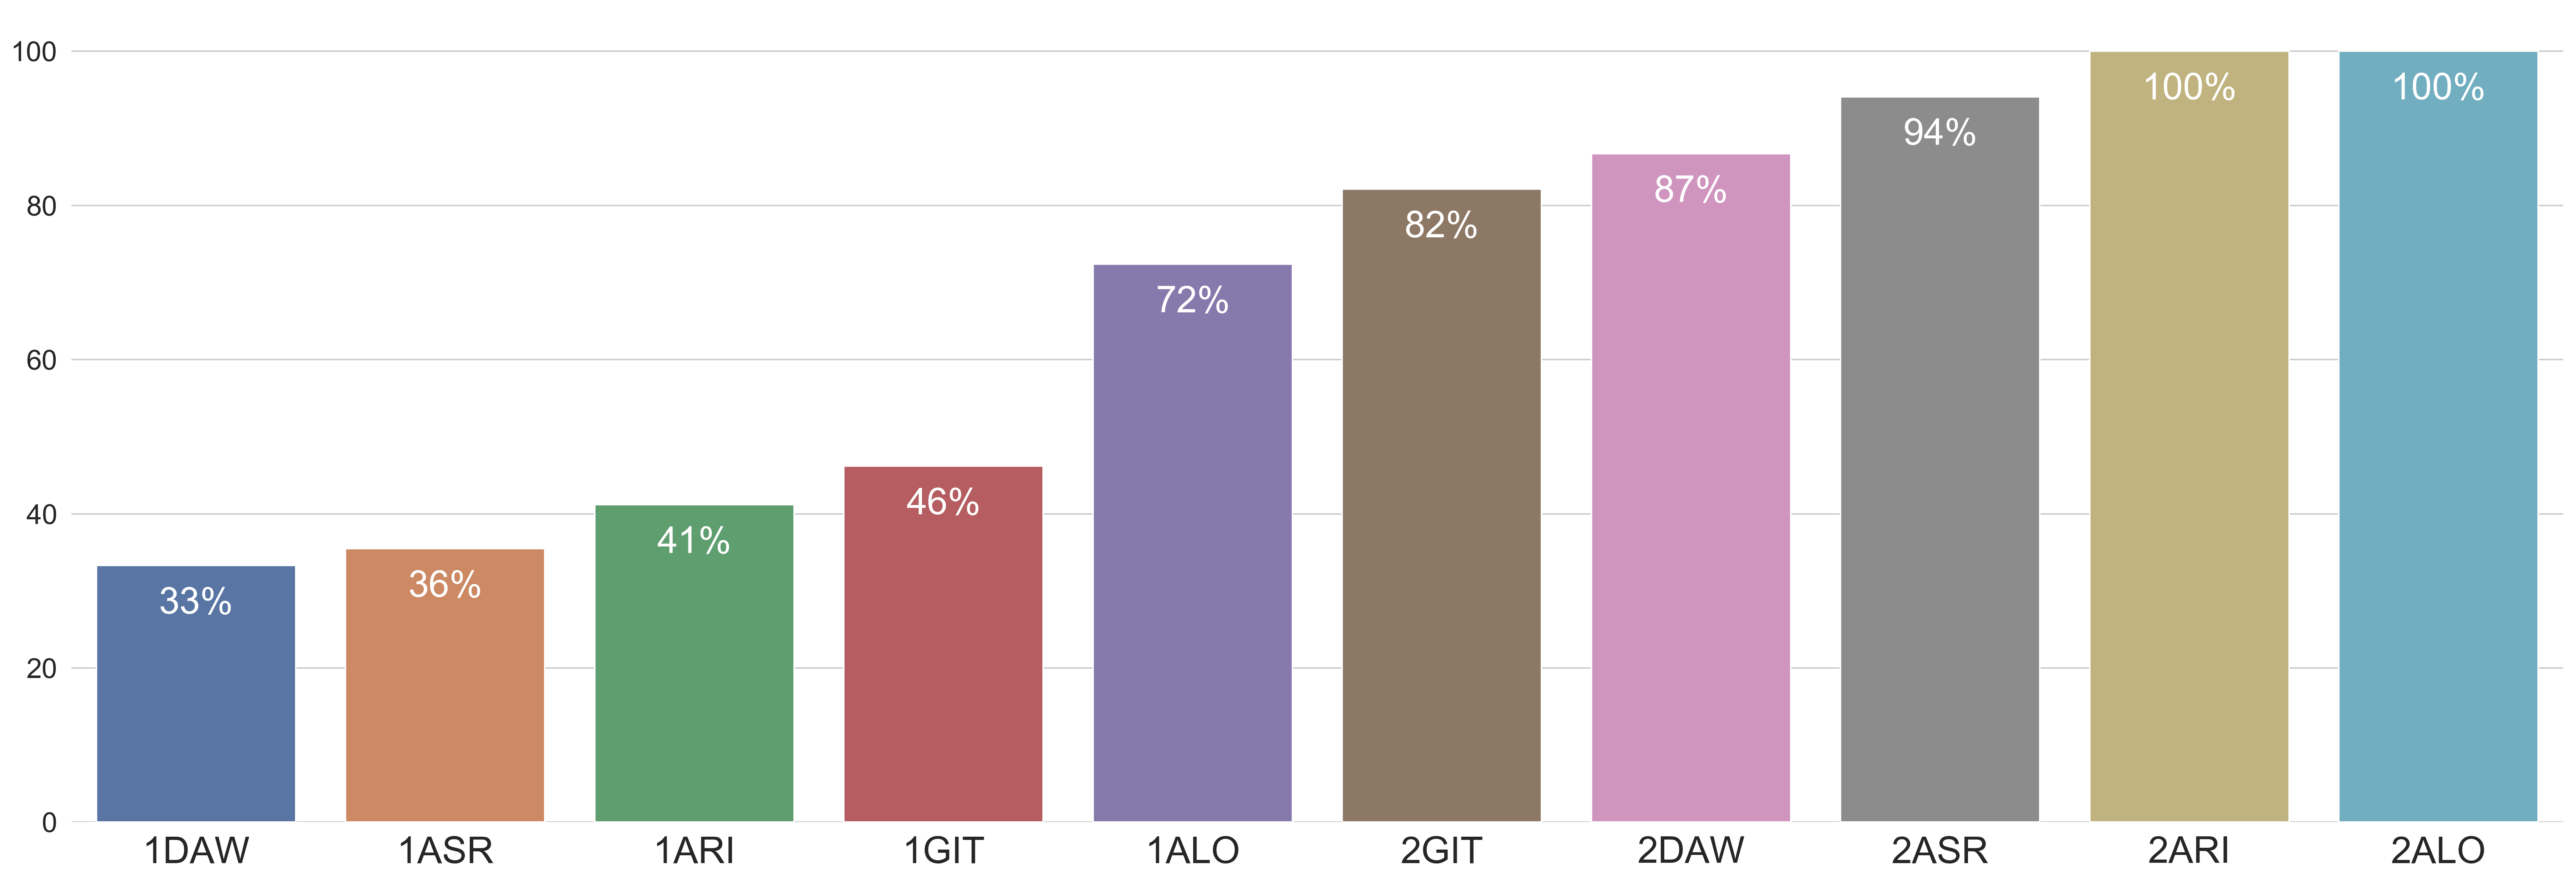

In [25]:
df_CFGS = get_data_by_stages(dfc, "CFGS")
bar_chart(df_CFGS["éxito"])

In [26]:
df_CFGS.mean()

éxito                       69.150
absentismo_justificado       2.456
absentismo_injustificado     8.464
partes                       0.000
suspensión_asistencia        0.000
ratio                       21.700
absentismo                  10.920
éxito_abs                   14.500
dtype: float64

## GLOBAL

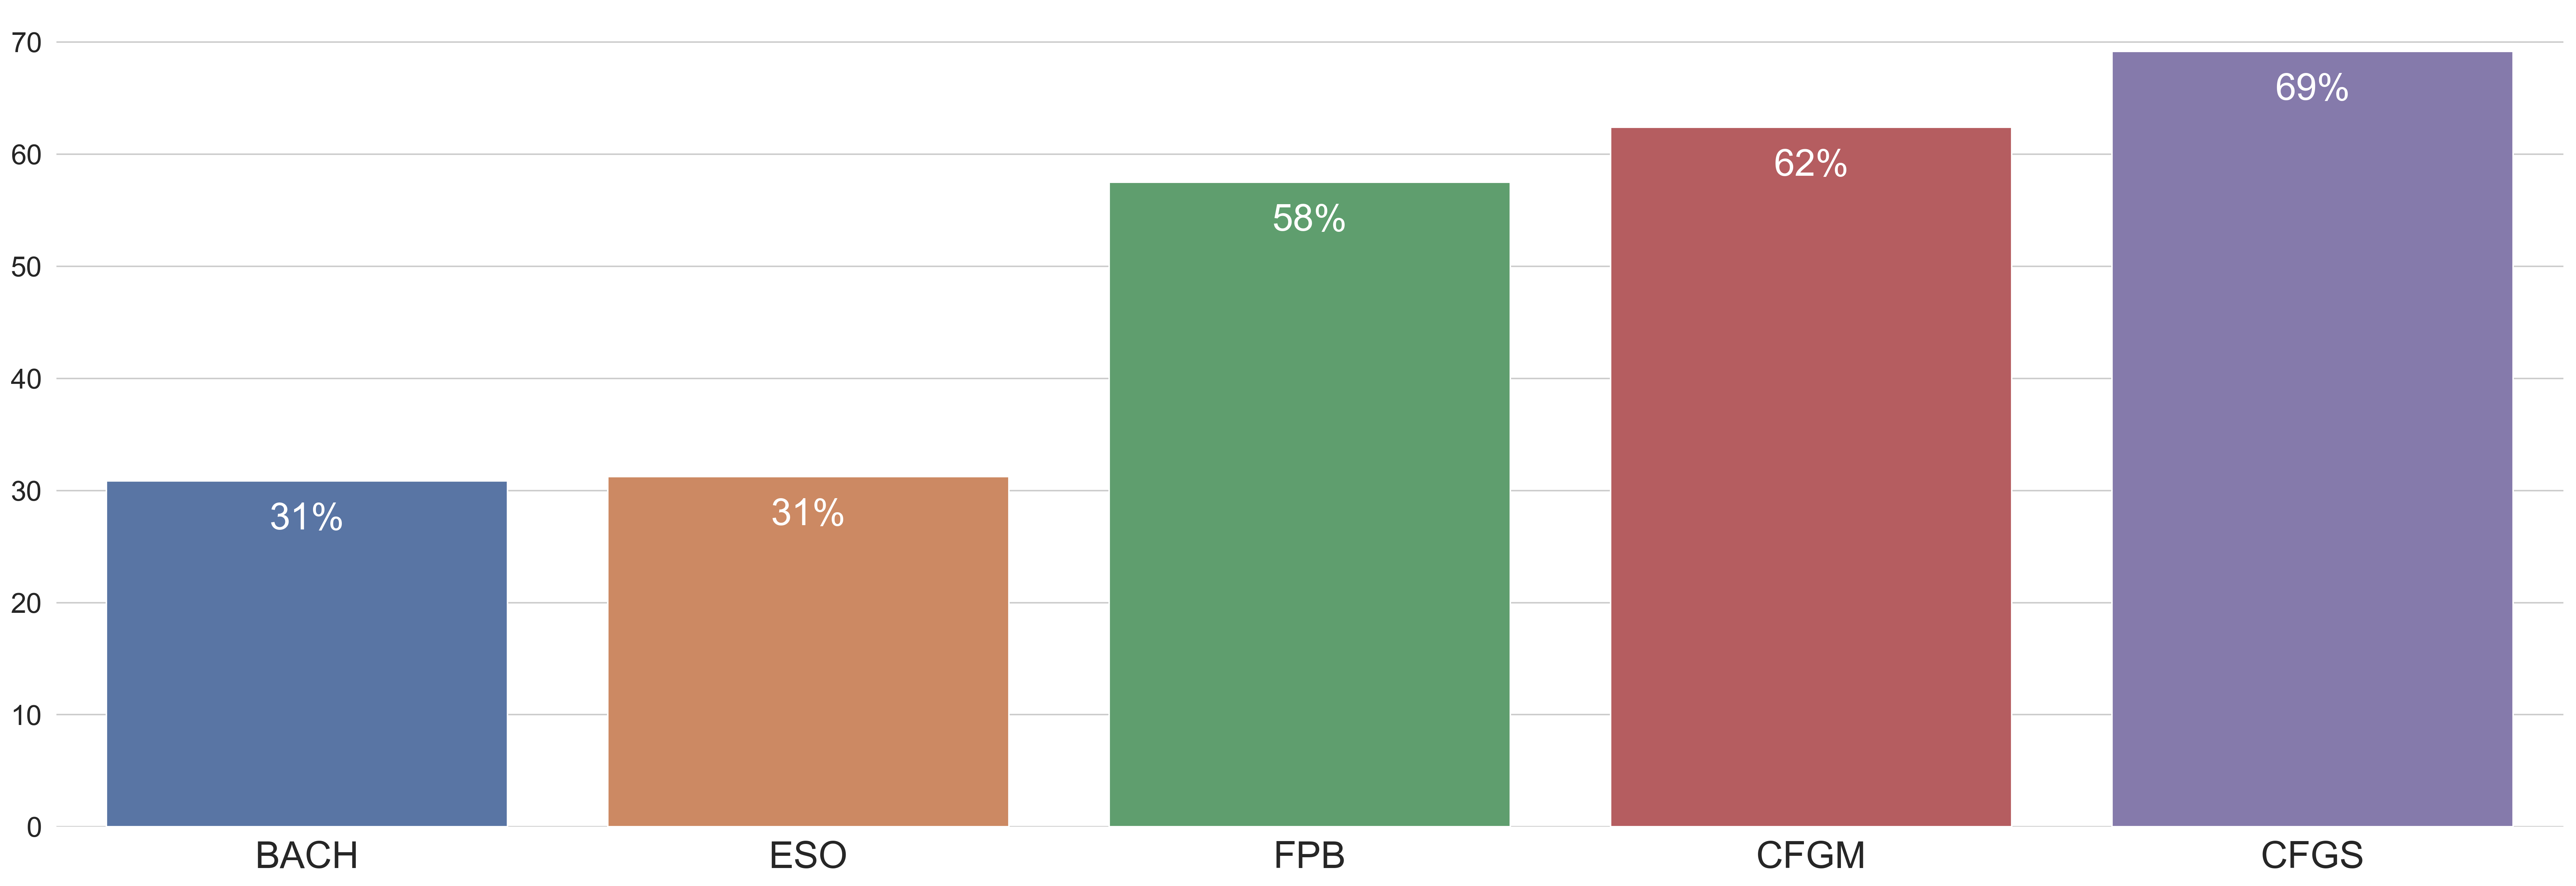

In [27]:
df_summary = dfc.groupby("etapa").mean()
bar_chart(df_summary["éxito"])

## COMPARATIVA CON LOS ÚLTIMOS CURSOS

<Figure size 9000x3000 with 0 Axes>

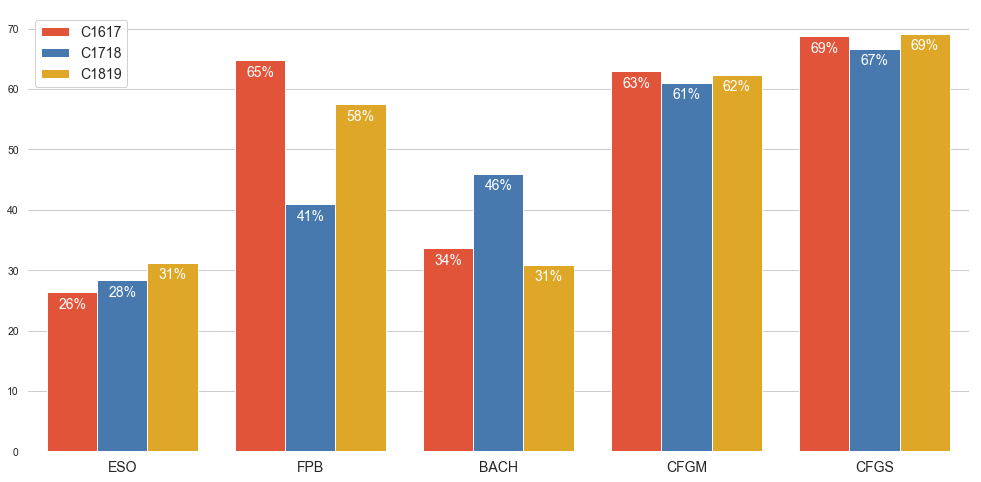

In [28]:
factor_chart(df.xs(labels[-1][1], level=1), "éxito")

In [29]:
mean_success = dfc["éxito"].mean()
display(HTML(f"""
<div class='alert alert-info' role='alert'>
    Éxito global medio: <b>{mean_success:.2f}</b>%
</div>
"""))

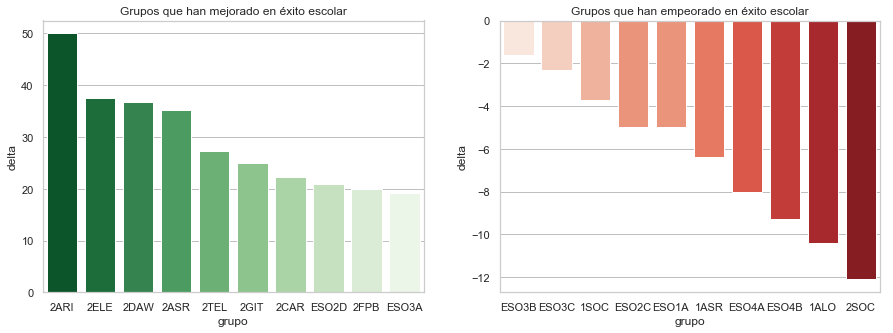

In [30]:
if EVALUATION > 1:
    display(HTML("<h2>EVOLUCIÓN DE GRUPOS CON RESPECTO A LA EVALUACIÓN ANTERIOR</h2>"))
    df_comp["delta"] = df_comp["éxito_x"] - df_comp["éxito_y"]
    df_comp = df_comp.sort_values("delta", ascending=False)
    delta_chart(df_comp[df_comp["delta"] > 0].head(10),
                df_comp[df_comp["delta"] < 0].head(10),
                label="éxito escolar")

## COMPETENCIAS BÁSICAS

**CL**: Comunicación lingüística.  
**CMCT**: Competencia matemática y competencias básicas en ciencia y tecnología.  
**CD**: Competencia digital.  
**AAP**: Aprender a aprender.  
**CSC**: Competencias sociales y cívicas.  
**SIEE**: Sentido de iniciativa y espíritu emprendedor.  
**CEC**: Conciencia y expresiones culturales.

#### Valor resumen por competencia básica:
\begin{equation}
MARCA = 0.025 * \mathbb{PA} + 0.050 * \mathbb{AD} + 0.075 * \mathbb{MA} + 0.1 * \mathbb{EX}
\end{equation}

, donde $\mathbb{PA}$, $\mathbb{AD}$, $\mathbb{MA}$ y $\mathbb{EX}$ son los porcentajes de adquisición de la competencia básica en cuestión.

In [31]:
COMPETENCE_CRITERIA = {
    "PA-%": "PA",
    "AD-%": "AD",
    "MA-%": "MA",
    "EX-%": "EX"
}

STUDIES = {
    "1º Educación Secundaria Obligatoria (LOMCE)": "1ESO",
    "2º Educación Secundaria Obligatoria (LOMCE)": "2ESO",
    "3º Educación Secundaria Obligatoria (LOMCE)": "3ESO",
    "4º Educación Secundaria Obligatoria (LOMCE)": "4ESO",
    "Primer curso del Programa de Mejora del Aprendizaje y el Rendimiento (LOMCE)": "1PMAR",
    "Segundo curso del Programa de Mejora del Aprendizaje y el Rendimiento (LOMCE)": "2PMAR"
}

COMPETENCE_ITEMS = {
    "Comunicación lingüística": "CL",
    "Competencia matemática y competencias básicas en ciencia y tecnología": "CMCT",
    "Competencia digital": "CD",
    "Aprender a aprender": "AAP",
    "Competencias sociales y cívicas": "CSC",
    "Sentido de iniciativa y espíritu emprendedor": "SIEE",
    "Conciencia y expresiones culturales": "CEC"
}

COMPETENCE_WEIGHTS = {
    "PA": 0.025,
    "AD": 0.050,
    "MA": 0.075,
    "EX": 0.1
}

# dataframe of basic competences
filename = "{}_ESO_CCBB.csv".format("".join(labels[-1]))
df_bc = pd.read_csv(os.path.join("../data/ccbb", filename),
                    encoding="cp1252", sep=";", skipfooter=9, engine="python")

df_bc = df_bc[df_bc["GRUPO"] != "TOTAL ESTUDIO"]

df_bc = df_bc.rename(columns=COMPETENCE_CRITERIA)
df_bc = df_bc[["ESTUDIO", "GRUPO", "ITEM", *COMPETENCE_CRITERIA.values()]]
df_bc["ESTUDIO"].replace(STUDIES, inplace=True)
df_bc["ITEM"].replace(COMPETENCE_ITEMS, inplace=True)

# summary value for each group-item
df_bc["MARCA"] = COMPETENCE_WEIGHTS["PA"] * df_bc["PA"] + \
                 COMPETENCE_WEIGHTS["AD"] * df_bc["AD"] + \
                 COMPETENCE_WEIGHTS["MA"] * df_bc["MA"] + \
                 COMPETENCE_WEIGHTS["EX"] * df_bc["EX"]

# grouped by groups
df_bc_grouped = df_bc.groupby("GRUPO").mean()["MARCA"]
index_with_right_order = dfc.index
dfc = pd.merge(dfc, pd.DataFrame(df_bc_grouped), left_index=True,
             right_index=True, how="outer", sort=False).rename(columns={"MARCA": "ccbb"})
dfc.index.name = "grupo"
dfc = dfc.loc[index_with_right_order]
dfc.head()

,etapa,éxito,absentismo_justificado,absentismo_injustificado,partes,suspensión_asistencia,ratio,absentismo,éxito_abs,ccbb
grupo,,,,,,,,,,
ESO1A,ESO,15.0,2.04,3.95,8.0,7.0,20,5.99,3.0,3.946429
ESO1B,ESO,47.4,0.94,5.74,0.0,0.0,19,6.68,9.0,5.203571
ESO1C,ESO,12.0,2.08,5.70,3.0,1.0,25,7.78,3.0,4.171429
ESO2A,ESO,53.6,2.69,3.83,2.0,1.0,28,6.52,15.0,4.928571
ESO2B,ESO,43.3,1.22,7.79,0.0,0.0,30,9.01,13.0,4.657143


In [32]:
df_bc.head()

,ESTUDIO,GRUPO,ITEM,PA,AD,MA,EX,MARCA
0,1ESO,ESO1A,CL,45,50,5,0,4.000
1,1ESO,ESO1A,CMCT,60,30,10,0,3.750
2,1ESO,ESO1A,CD,30,70,0,0,4.250
3,1ESO,ESO1A,AAP,45,50,5,0,4.000
4,1ESO,ESO1A,CSC,50,45,5,0,3.875


### ESTUDIO POR NIVELES Y COMPETENCIA

<Figure size 9000x3000 with 0 Axes>

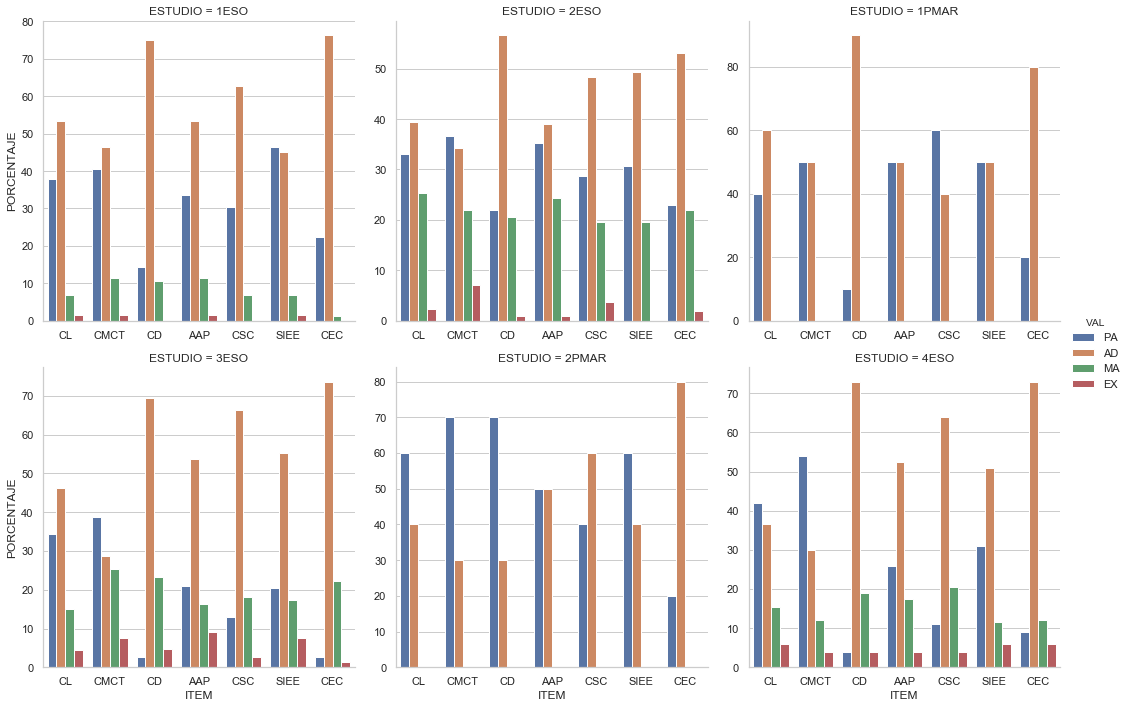

In [33]:
df_bc_melted = pd.melt(df_bc, ["ESTUDIO", "GRUPO", "ITEM"], [
                       "PA", "AD", "MA", "EX"], var_name="VAL", value_name="PORCENTAJE")
plt.figure(figsize=(30, 10), dpi=FIGURE_DPI)
sns.catplot(x="ITEM", y="PORCENTAJE", hue="VAL", col="ESTUDIO",
               data=df_bc_melted, col_wrap=3, kind="bar", sharex=False, sharey=False, ci=None);

## Análisis simplificado por competencias básicas

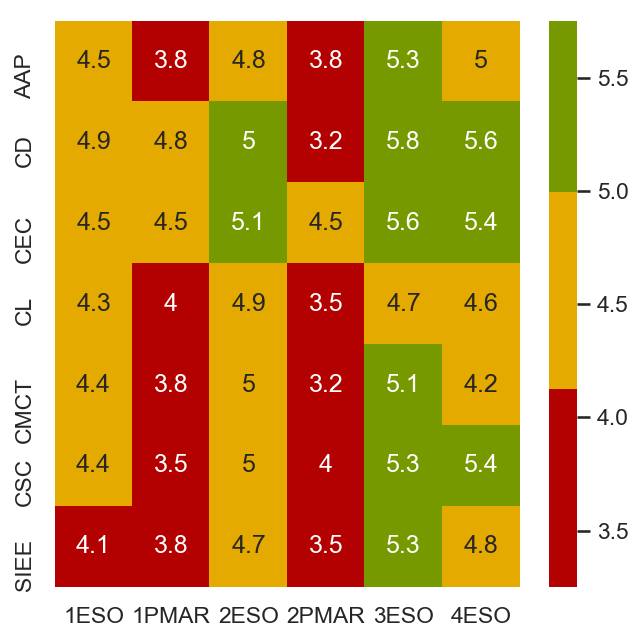

In [34]:
cdict = {
    "red":   ((0.0, 1.0, 0.7),
              (0.5, 1.0, 0.7),
              (1.0, 0.0, 0.0)),
    "green": ((0.0, 0.0, 0.0),
              (0.5, 1.0, 0.4),
              (1.0, 1.0, 0.4)),
    "blue":  ((0.0, 0.0, 0.0),
              (1.0, 0.0, 0.0))
}
from matplotlib.colors import LinearSegmentedColormap

z = df_bc.groupby(['ESTUDIO', 'ITEM']).mean().reset_index().pivot("ITEM", "ESTUDIO", "MARCA")
plt.figure(figsize=(5, 5), dpi=FIGURE_DPI // 2)
cmap = LinearSegmentedColormap("custom_cmap", cdict, 4)
sns.heatmap(z, annot=True, cmap=cmap, center=5)
# hide axis labels
plt.xlabel("")
plt.ylabel("")
# hide ticks
plt.tick_params(top=False, bottom=False, left=False,
                right=False, labelleft=True, labelbottom=True)

### Nivel competencial resumen por estudios

In [35]:
df_bc["MARCA"].groupby(df_bc["ESTUDIO"]).mean().sort_values(ascending=False)

ESTUDIO
3ESO     5.291667
4ESO     4.989286
2ESO     4.922619
1ESO     4.440476
1PMAR    4.000000
2PMAR    3.678571
Name: MARCA, dtype: float64

### Nivel competencial resumen por competencias básicas

In [36]:
df_bc["MARCA"].groupby(df_bc["ITEM"]).mean().sort_values(ascending=False)

ITEM
CD      5.094231
CEC     5.005769
CSC     4.790385
AAP     4.717308
SIEE    4.559615
CL      4.513462
CMCT    4.500000
Name: MARCA, dtype: float64

### Máximo nivel competencial

In [37]:
df_bc.loc[df_bc["MARCA"].idxmax()][["GRUPO", "ITEM", "MARCA"]]

GRUPO    ESO3B
ITEM        CD
MARCA    6.075
Name: 79, dtype: object

### Mínimo nivel competencial

In [38]:
df_bc.loc[df_bc["MARCA"].idxmin()][["GRUPO", "ITEM", "MARCA"]]

GRUPO    ESO3D
ITEM      CMCT
MARCA     3.25
Name: 99, dtype: object

# ABSENTISMO

<div class="alert alert-success" role="alert">
    ABSENTISMO = <b>Faltas justificadas + Faltas injustificadas</b>
</div>

**Se va a estudiar el ABSENTISMO ACUMULADO desde el 1 de septiembre hasta la fecha de finalización del trimestre de análisis.**

## ABSENTISMO TOTAL vs ABSENTISMO JUSTIFICADO

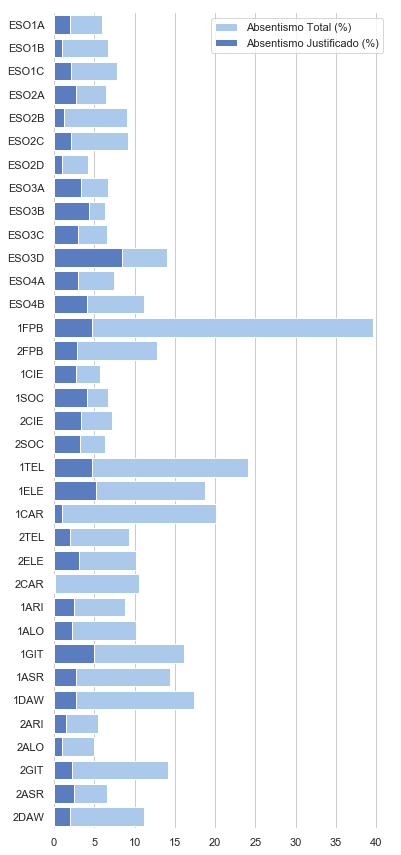

In [39]:
stacked_chart(dfc.reset_index(), "grupo", "absentismo",
              "absentismo_justificado", "Absentismo Total (%)", "Absentismo Justificado (%)")

## ESO + FPB

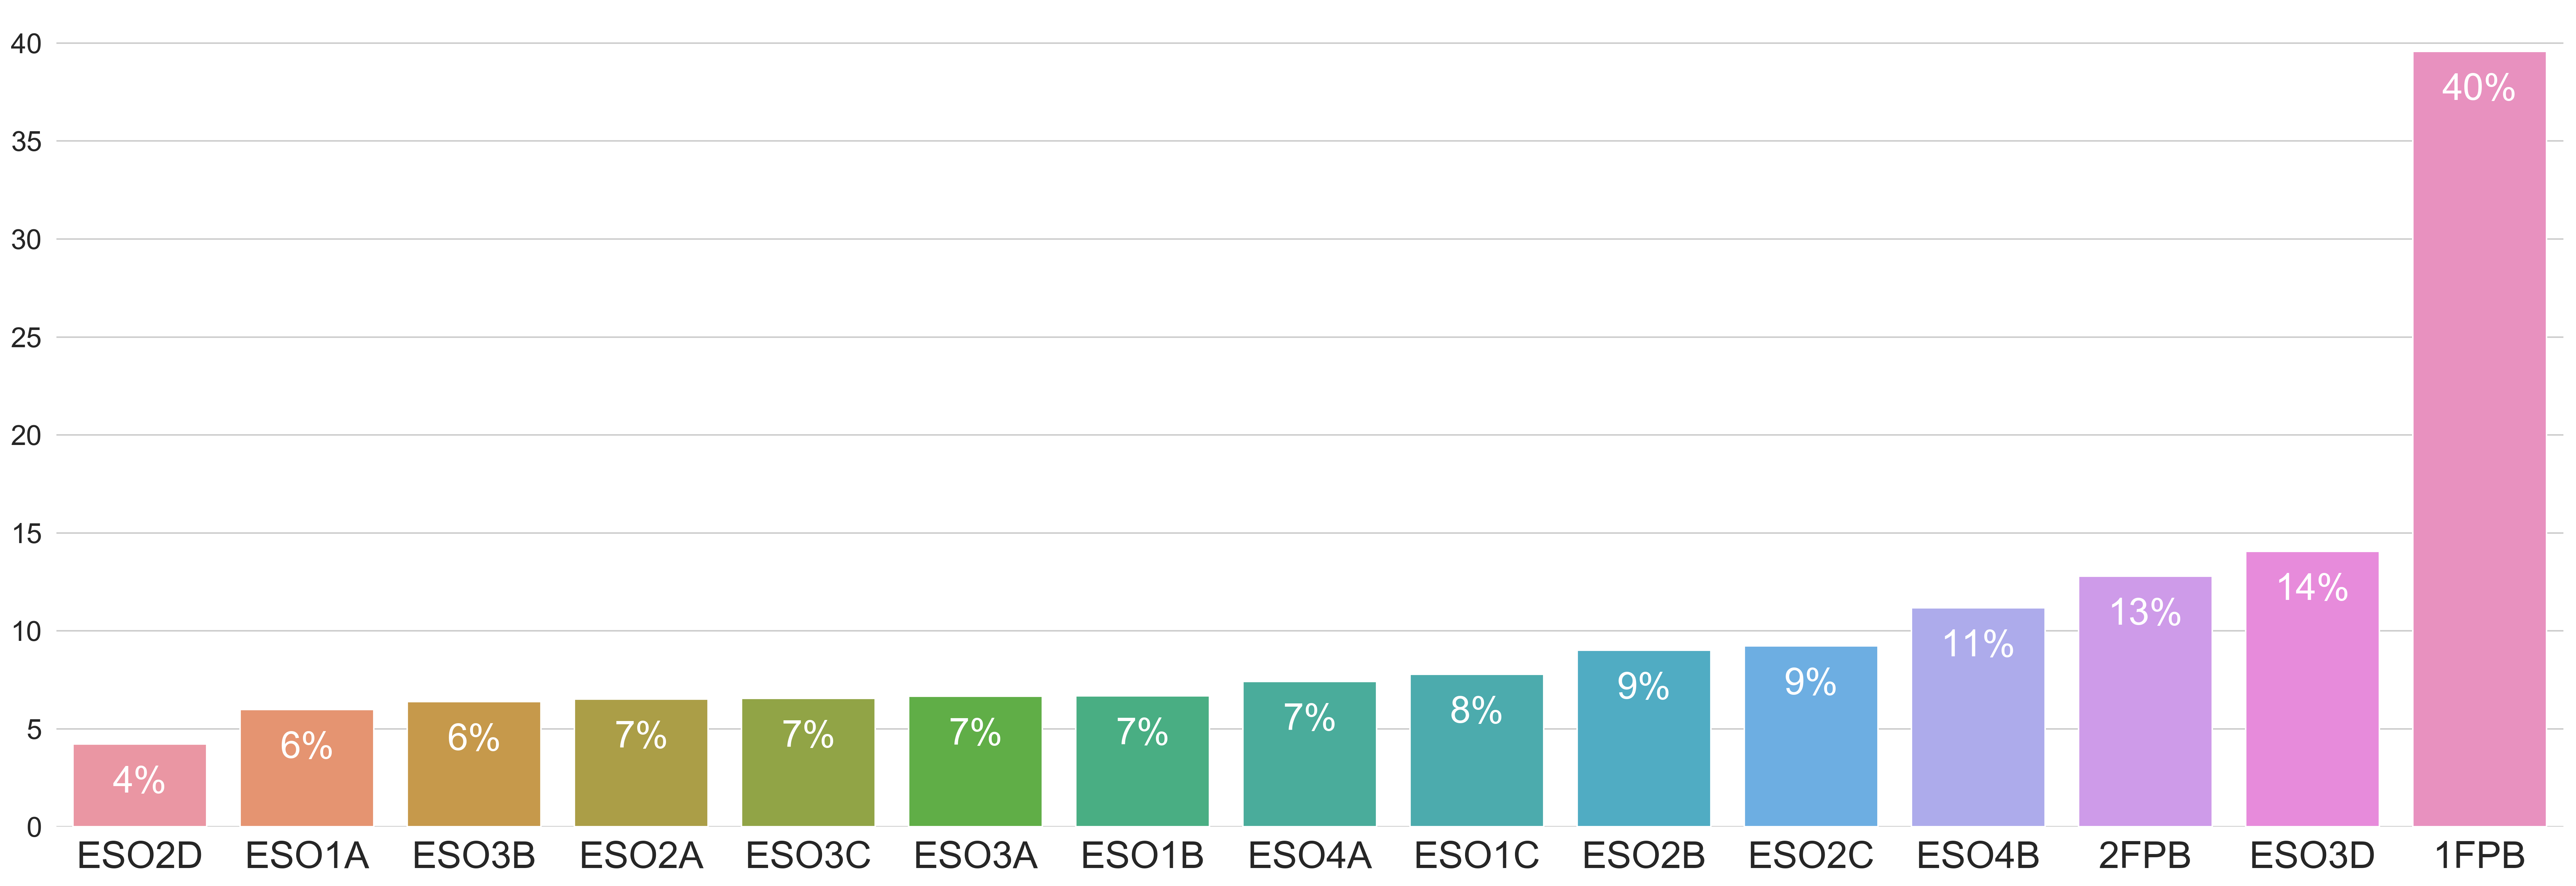

In [40]:
bar_chart(df_ESOFPB["absentismo"])

## BACHILLERATO

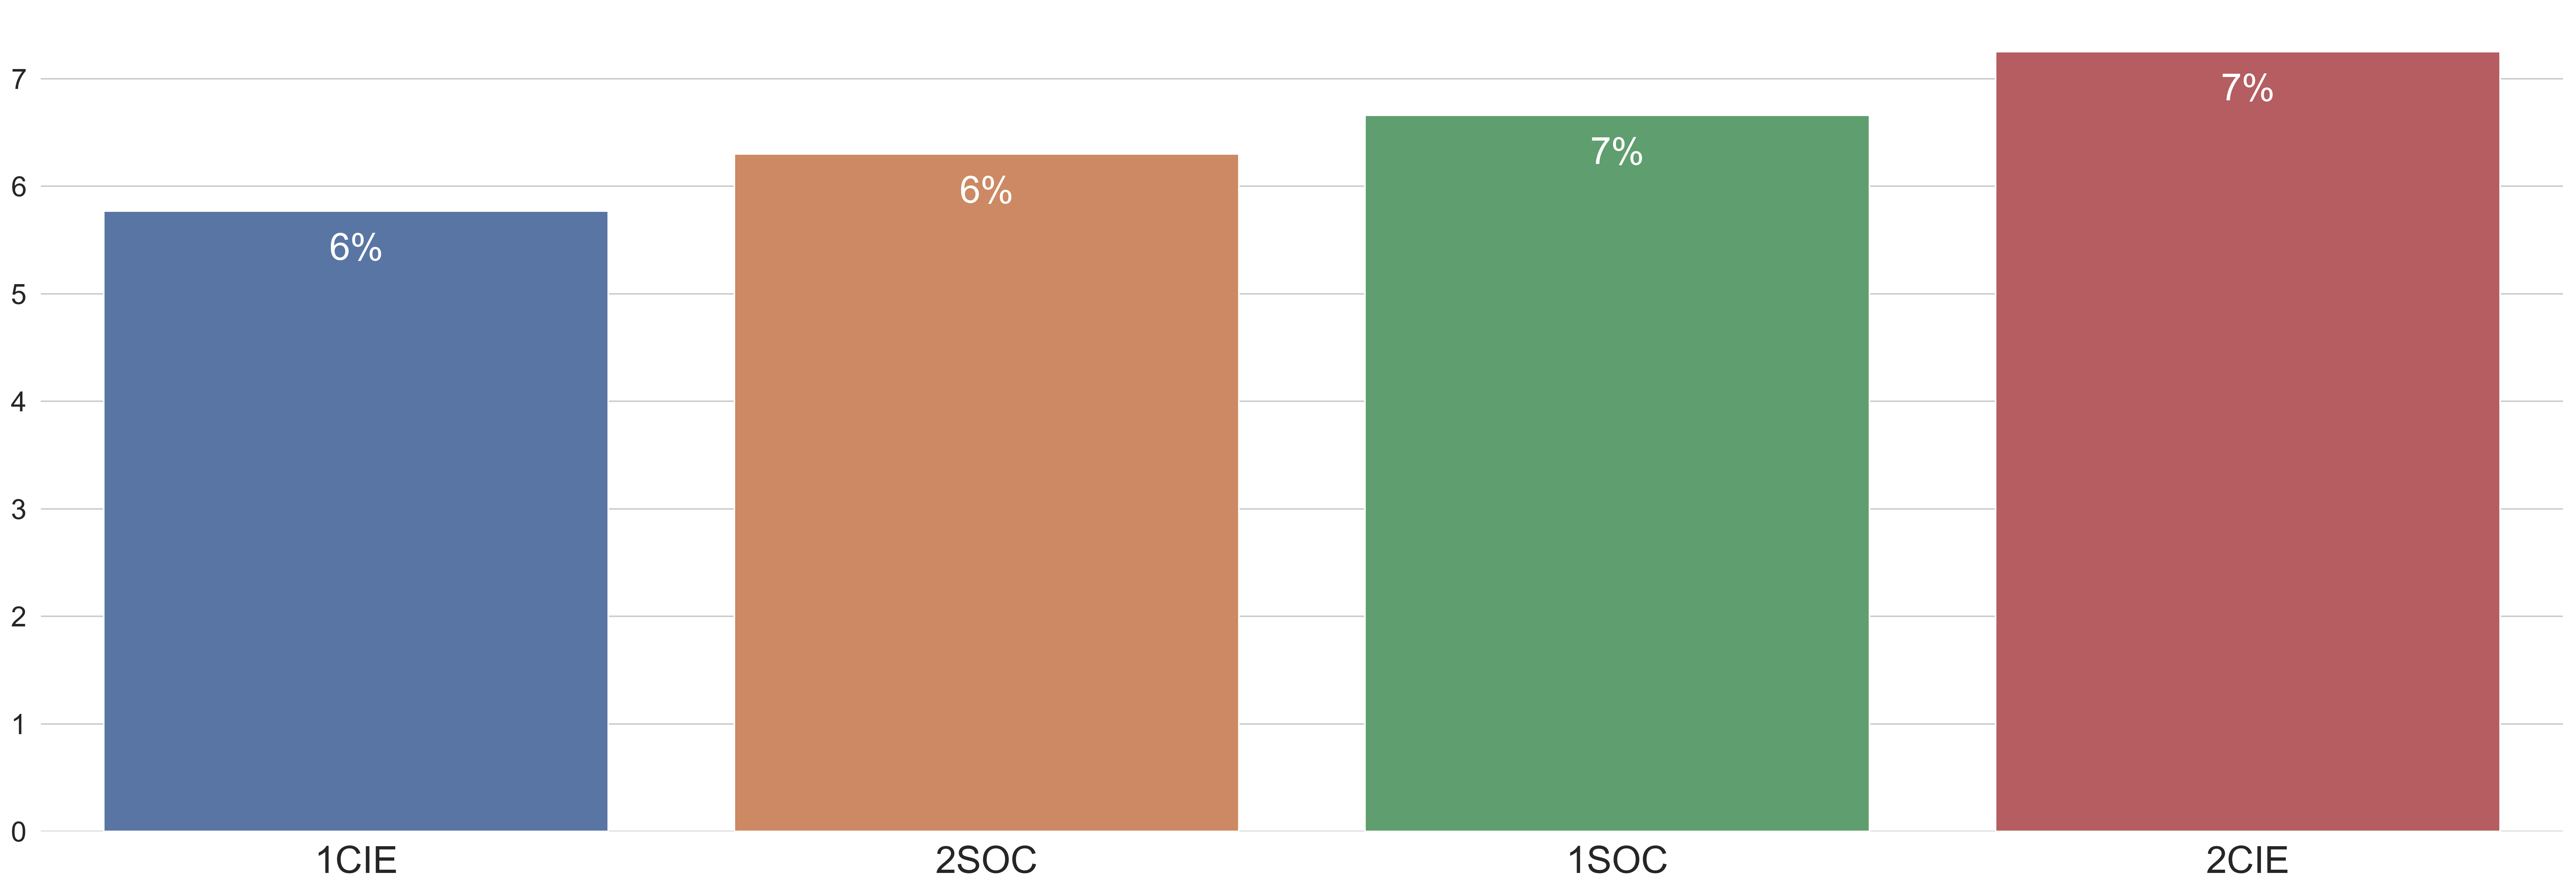

In [41]:
bar_chart(df_BACH["absentismo"])

## CICLOS FORMATIVOS DE GRADO MEDIO

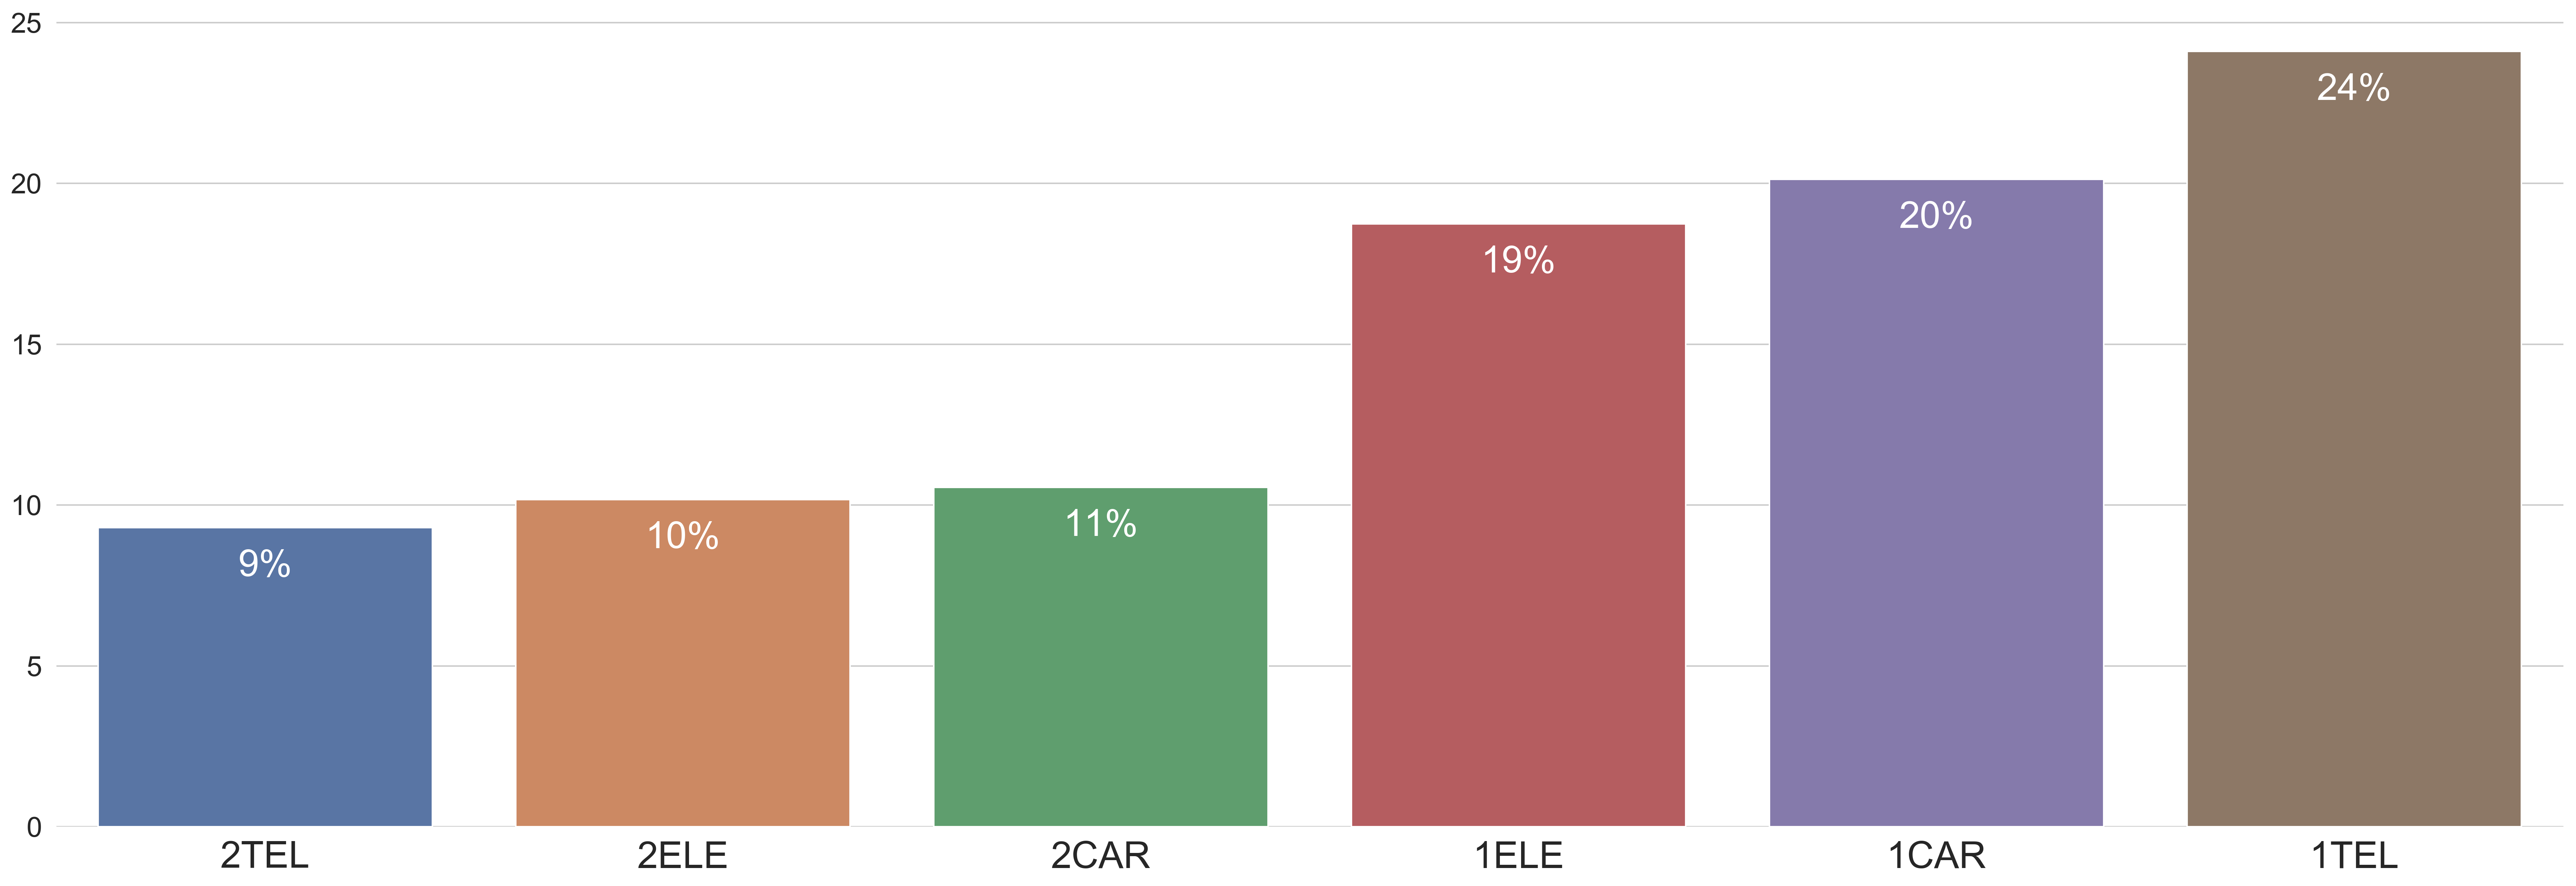

In [42]:
bar_chart(df_CFGM["absentismo"])

## CICLOS FORMATIVOS DE GRADO SUPERIOR

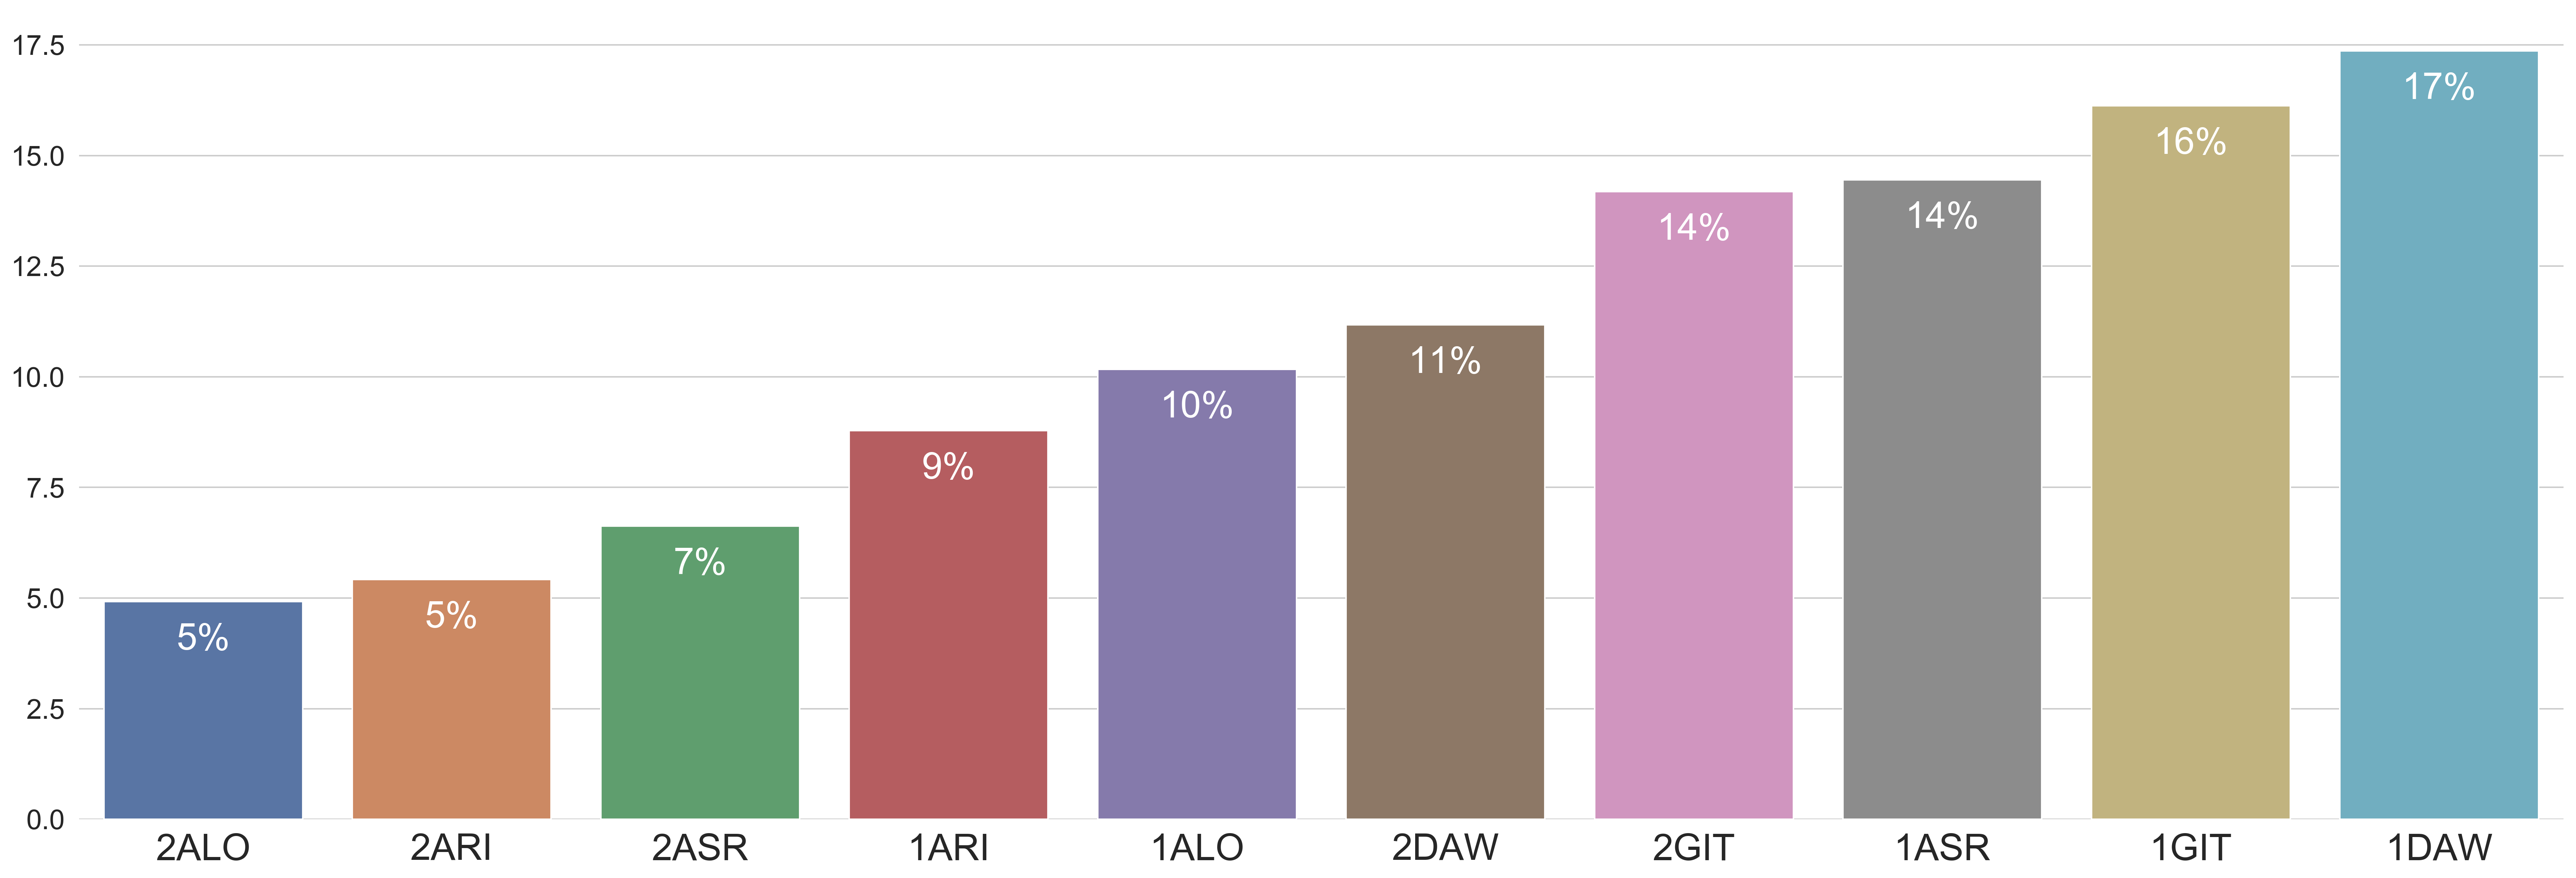

In [43]:
bar_chart(df_CFGS["absentismo"])

## GLOBAL

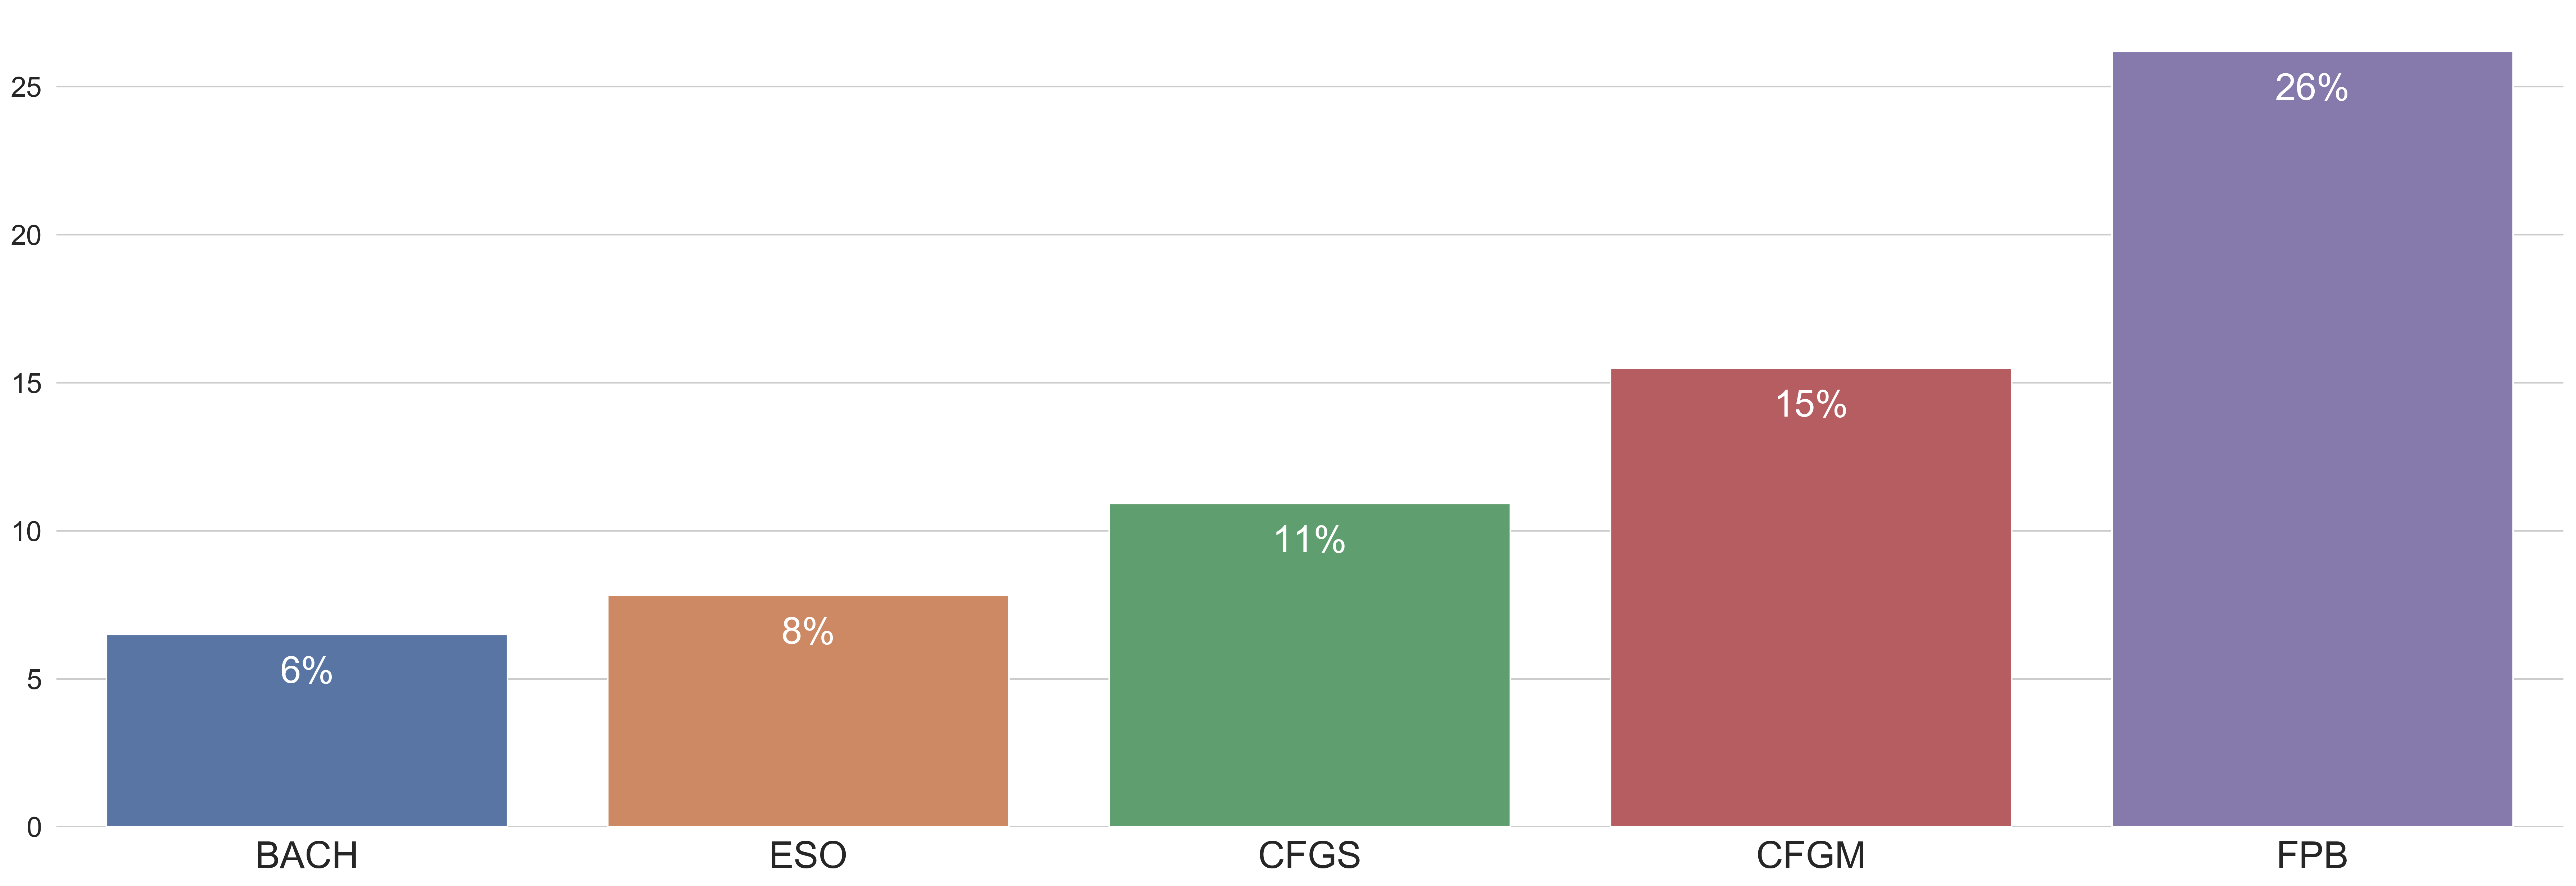

In [44]:
bar_chart(df_summary["absentismo"])

## COMPARATIVA CON LOS ÚLTIMOS CURSOS

<Figure size 9000x3000 with 0 Axes>

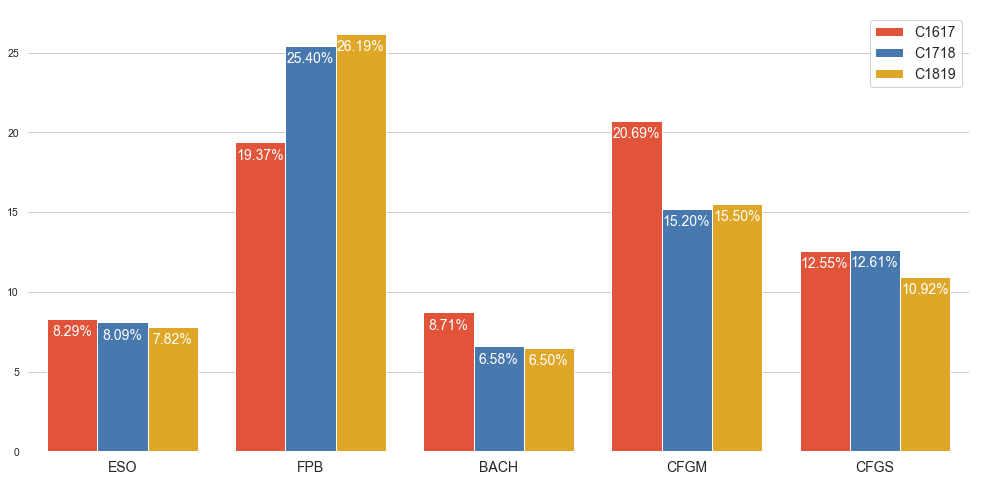

In [45]:
factor_chart(df.xs(labels[-1][1], level=1), "absentismo", .8, show_integer=False)

In [46]:
mean_absence = dfc["absentismo"].mean()
display(HTML(f"""
<div class='alert alert-info' role='alert'>
    Absentismo global medio: <b>{mean_absence:.2f}</b>%
</div>
"""))

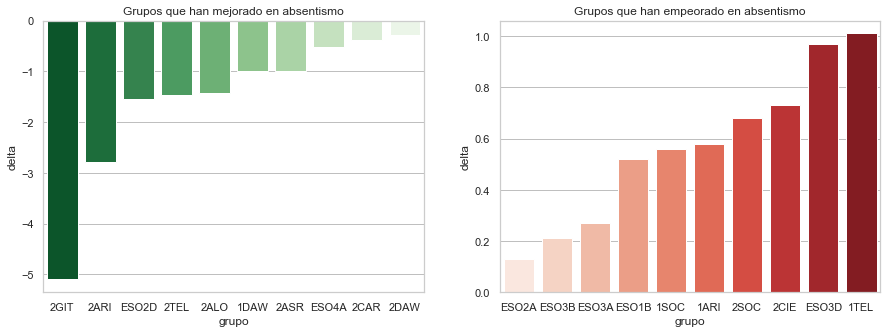

In [47]:
if EVALUATION > 1:
    display(HTML("<h2>EVOLUCIÓN DE GRUPOS CON RESPECTO A LA EVALUACIÓN ANTERIOR"))
    df_comp["delta"] = df_comp["absentismo_x"] - df_comp["absentismo_y"]
    df_comp = df_comp.sort_values("delta")
    delta_chart(df_comp[df_comp["delta"] < 0].head(10),
                df_comp[df_comp["delta"] > 0].head(10),
                label="absentismo", inverse=True)

# GESTIÓN DE LA CONVIVENCIA

## PARTES DE GESTIÓN

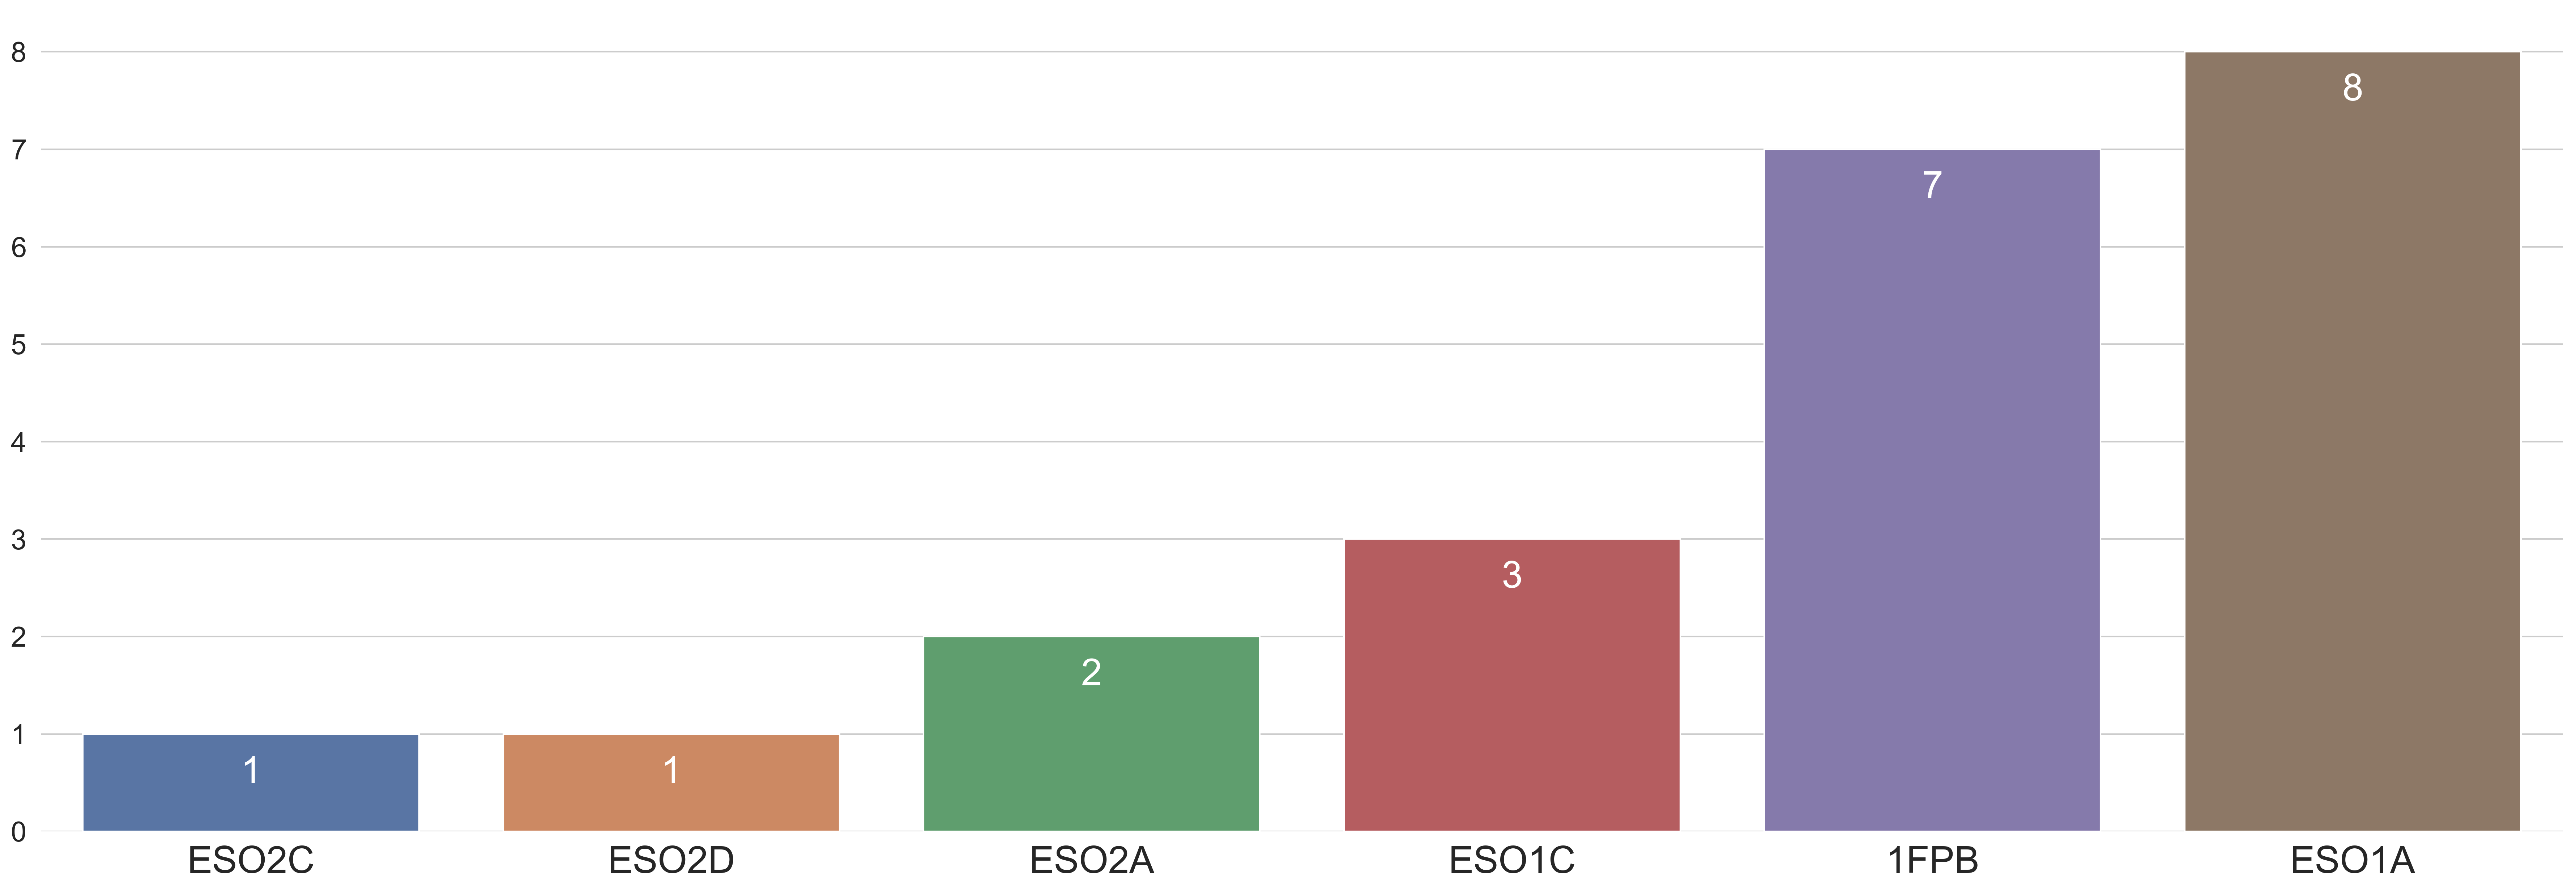

In [48]:
df_reports = dfc[dfc["partes"] > 0]["partes"]
bar_chart(df_reports, False)

## COMPARATIVA CON LOS ÚLTIMOS CURSOS

<Figure size 9000x3000 with 0 Axes>

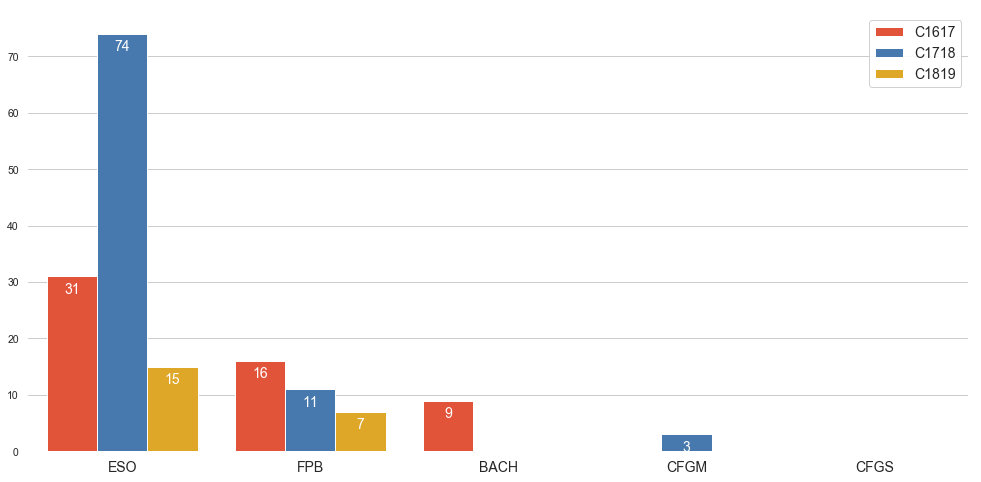

In [49]:
factor_chart(df.xs(labels[-1][1], level=1), "partes", 2.3, False, np.sum)

In [50]:
total_reports = df_reports.sum()
display(HTML(f"""
<div class='alert alert-info' role='alert'>
    Total de partes de gestión: <b>{total_reports:.0f}</b>
</div>
"""))

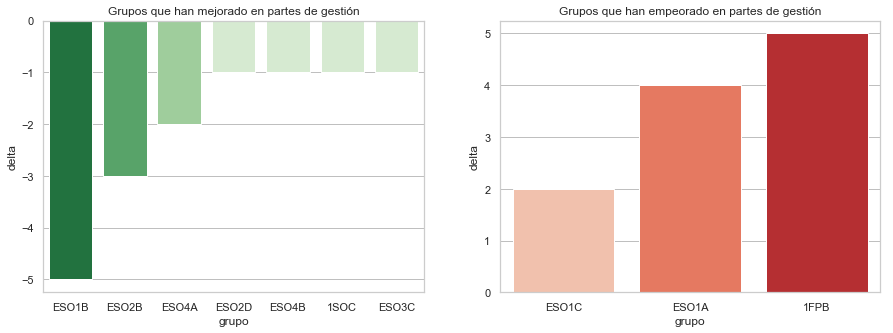

In [51]:
if EVALUATION > 1:
    display(HTML("<h2>EVOLUCIÓN DE GRUPOS CON RESPECTO A LA EVALUACIÓN ANTERIOR"))
    df_comp["delta"] = df_comp["partes_x"] - df_comp["partes_y"]
    df_comp = df_comp.sort_values("delta")
    delta_chart(df_comp[df_comp["delta"] < 0].head(10),
                df_comp[df_comp["delta"] > 0].head(10),
                label="partes de gestión", inverse=True)

## SUSPENSIÓN DEL DERECHO DE ASISTENCIA

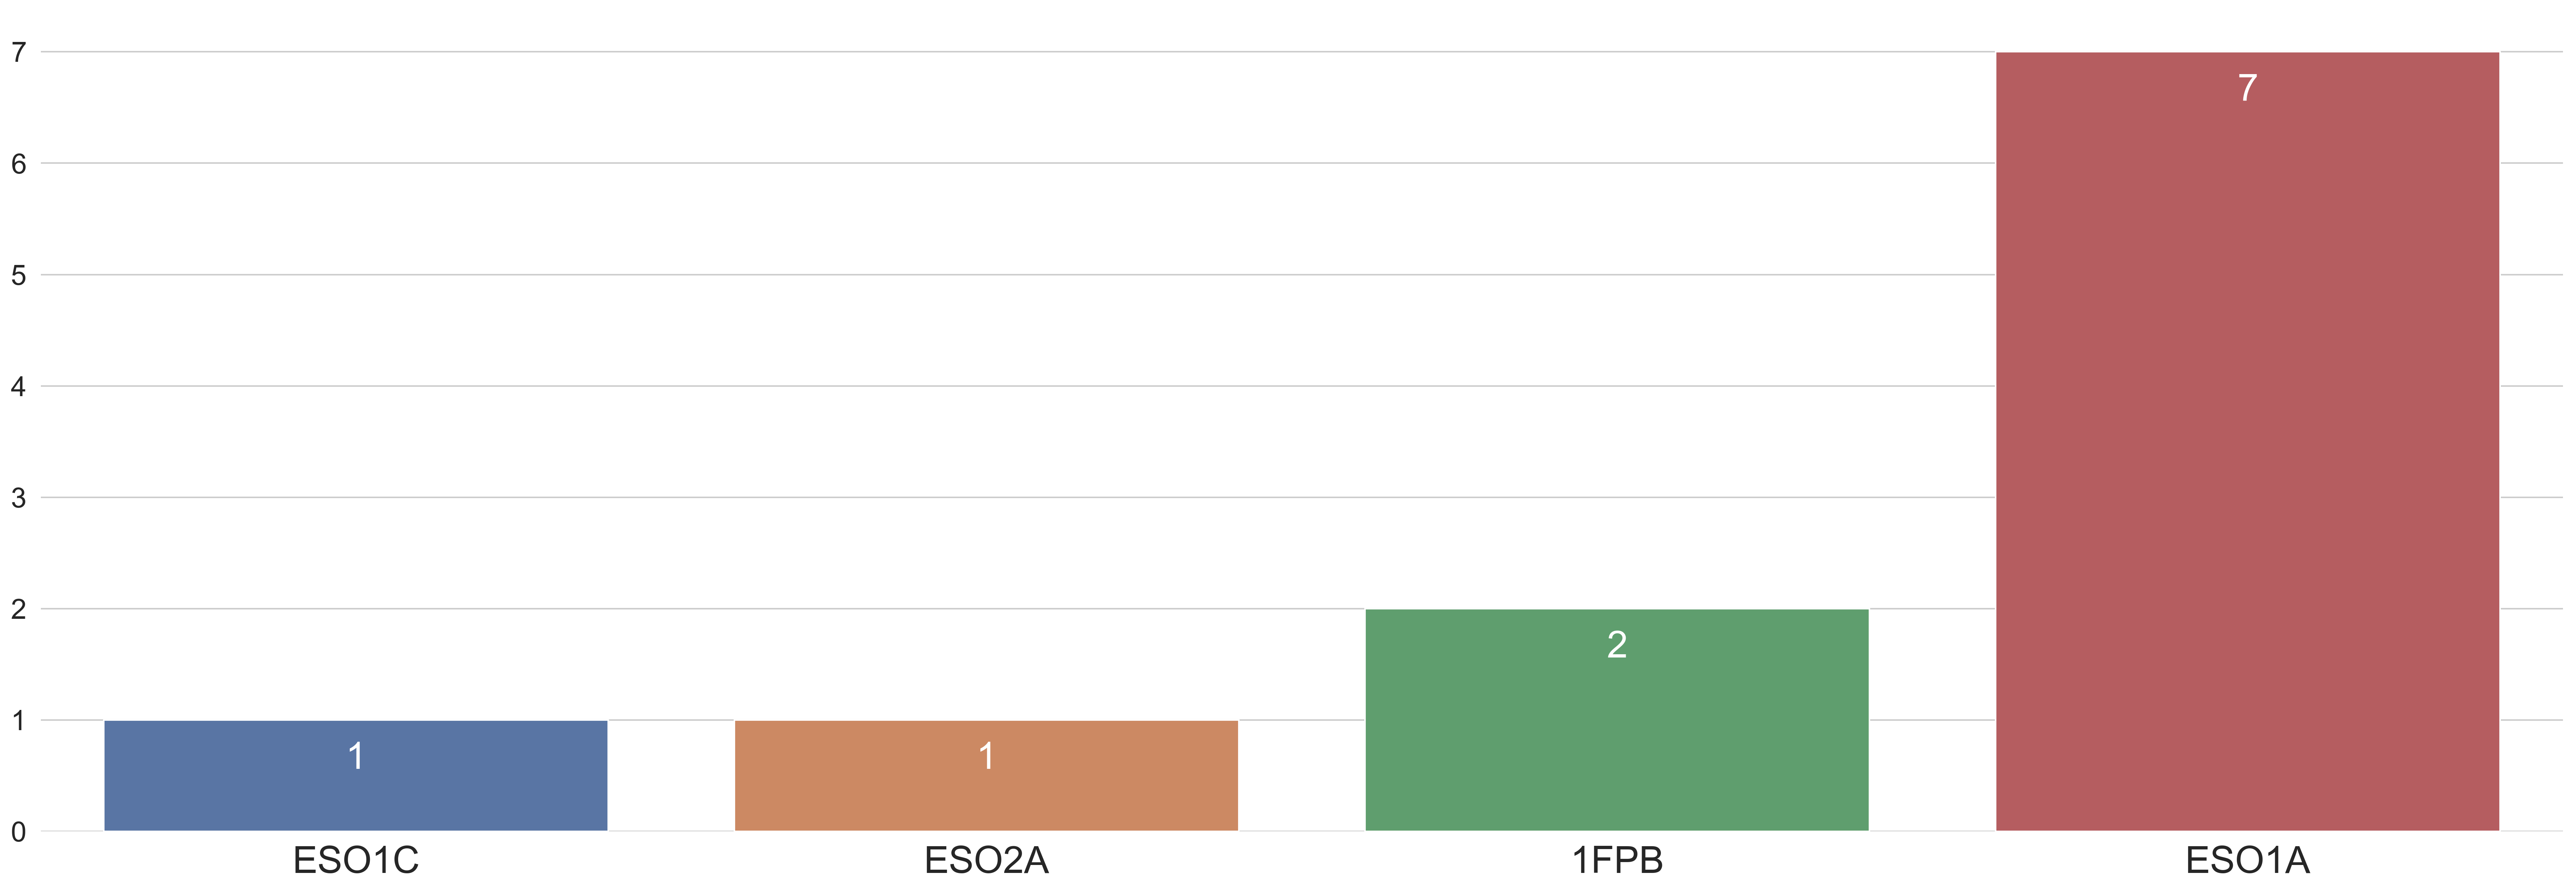

In [52]:
df_non_attendance = dfc[dfc["suspensión_asistencia"] > 0]["suspensión_asistencia"]
bar_chart(df_non_attendance, False)

## COMPARATIVA CON LOS ÚLTIMOS CURSOS

<Figure size 9000x3000 with 0 Axes>

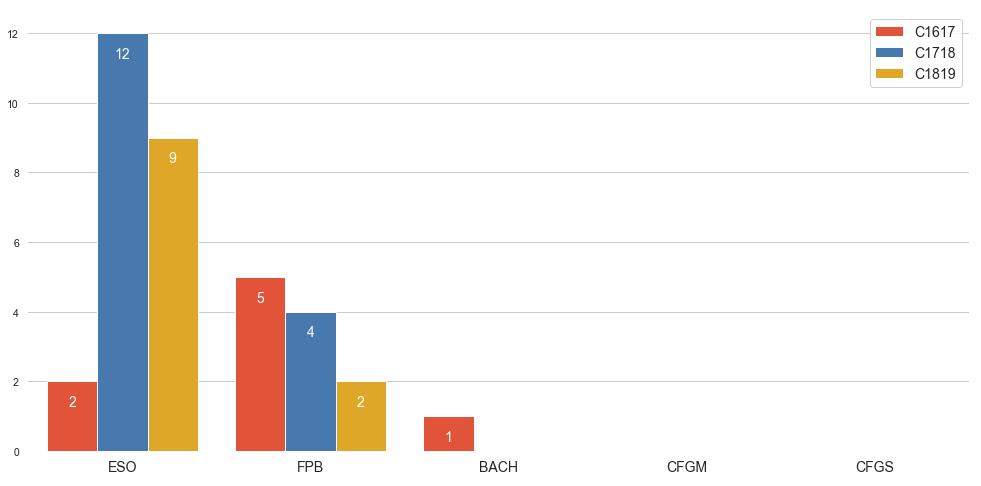

In [53]:
factor_chart(df.xs(labels[-1][1], level=1),
             "suspensión_asistencia", .6, False, np.sum)

In [54]:
total_non_attendance = df_non_attendance.sum()
display(HTML(f"""
<div class='alert alert-info' role='alert'>
    Total de partes de gestión con <b>suspensión</b> del derecho de asistencia: <b>{total_non_attendance:.0f}</b>
</div>
"""))

# RELACIÓN `éxito-competencias básicas`

> **NOTA**: Análisis únicamente con grupos de la ESO.

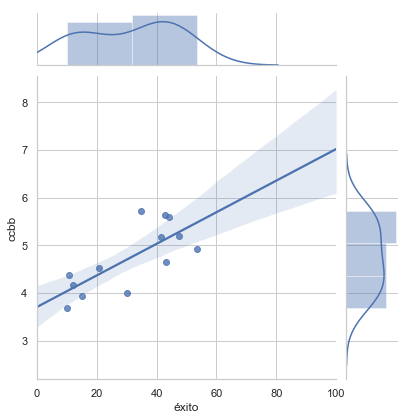

In [55]:
sns.jointplot("éxito", "ccbb", dfc, kind="reg", xlim=(0, 100));

In [56]:
corr = dfc.corrwith(dfc['éxito'])['ccbb']
display(HTML(f'''
    <div class='alert alert-success' role='alert'>
        COEFICIENTE DE CORRELACIÓN: <b>{corr:.4f}</b>
    </div>
'''))

## Detección de *outliers*

### Bajo éxito y alta adquisición de competencias básicas

In [57]:
dfc[(dfc["éxito"] < 20) & (dfc["ccbb"] > 5)][["éxito", "ccbb"]]

,éxito,ccbb
grupo,,


### Alto éxito y baja adquisición de competencias básicas

In [58]:
dfc[(dfc["éxito"] > 50) & (dfc["ccbb"] < 4)][["éxito", "ccbb"]]

,éxito,ccbb
grupo,,


# RELACIÓN `ratio-éxito`

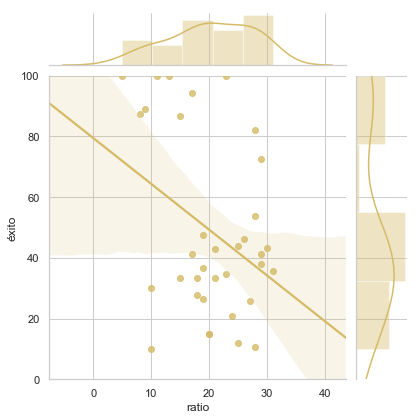

In [59]:
sns.jointplot("ratio", "éxito", dfc, kind="reg", ylim=(0, 100), color="y");

In [60]:
corr = dfc.corrwith(dfc['ratio'])['éxito']
display(HTML(f'''
    <div class='alert alert-success' role='alert'>
        COEFICIENTE DE CORRELACIÓN: <b>{corr:.4f}</b>
    </div>
'''))

## Detección de *outliers*

### Baja ratio y bajo éxito

In [61]:
dfc[(dfc["ratio"] < 20) & (dfc["éxito"] < 20)][["ratio", "éxito"]]

,ratio,éxito
grupo,,
ESO3D,10,10.0


### Alta ratio y alto éxito

In [62]:
dfc[(dfc["ratio"] > 25) & (dfc["éxito"] > 50)][["ratio", "éxito"]]

,ratio,éxito
grupo,,
ESO2A,28,53.6
1ALO,29,72.4
2GIT,28,82.1


# RELACIÓN `absentismo-éxito`

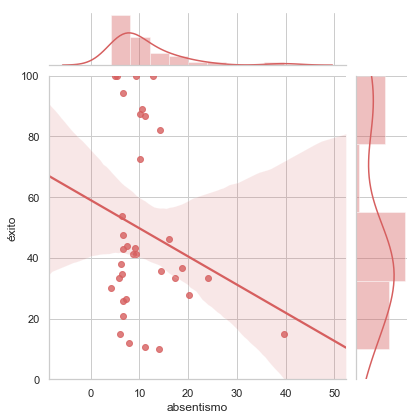

In [63]:
sns.jointplot("absentismo", "éxito", dfc, kind="reg", color="r", ylim=(0, 100));

In [64]:
corr = dfc.corrwith(dfc['absentismo'])['éxito']
display(HTML(f'''
    <div class='alert alert-success' role='alert'>
        COEFICIENTE DE CORRELACIÓN: <b>{corr:.4f}</b>
    </div>
'''))

## Detección de *outliers*

### Bajo absentismo y bajo éxito

In [67]:
dfc[(dfc["absentismo"] < 10) & (dfc["éxito"] < 15)][["absentismo", "éxito"]]

,absentismo,éxito
grupo,,
ESO1C,7.78,12.0


### Alto absentismo y alto éxito

In [68]:
dfc[(dfc["absentismo"] > 25) & (dfc["éxito"] > 50)][["absentismo", "éxito"]]

,absentismo,éxito
grupo,,


# RELACIÓN `partes-éxito`

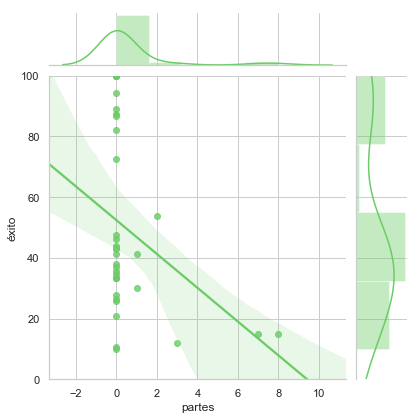

In [74]:
sns.jointplot("partes", "éxito", dfc, kind="reg", color="g", ylim=(0, 100));

In [75]:
corr = dfc.corrwith(dfc['partes'])['éxito']
display(HTML(f'''
    <div class='alert alert-success' role='alert'>
        COEFICIENTE DE CORRELACIÓN: <b>{corr:.4f}</b>
    </div>
'''))

## Detección de *outliers*

### Bajo número de partes y bajo éxito

In [76]:
dfc[(dfc["partes"] < 10) & (dfc["éxito"] < 10)][["partes", "éxito"]]

,partes,éxito
grupo,,


### Alto número de partes y alto éxito

In [77]:
dfc[(dfc["partes"] > 15) & (dfc["éxito"] > 30)][["partes", "éxito"]]

,partes,éxito
grupo,,


# GRUPOS MÁGICOS

> Son aquellos que tienen mejores valores de éxito escolar, menor absentismo y menos partes de gestión.

\begin{equation}
magic = 0.6 · success + 0.2 · e^{-absence} + 0.2 · e^{-reports}
\end{equation}

In [78]:
df2 = dfc.copy()
df2["magic"] = 0.6 * df2["éxito"] + 0.2 * \
    np.exp(-df2["absentismo"]) + 0.2 * np.exp(-df2["partes"])
magic = df2.sort_values("magic", ascending=False)

/Users/sdelquin/.virtualenvs/analitica-qCQ9lybR/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


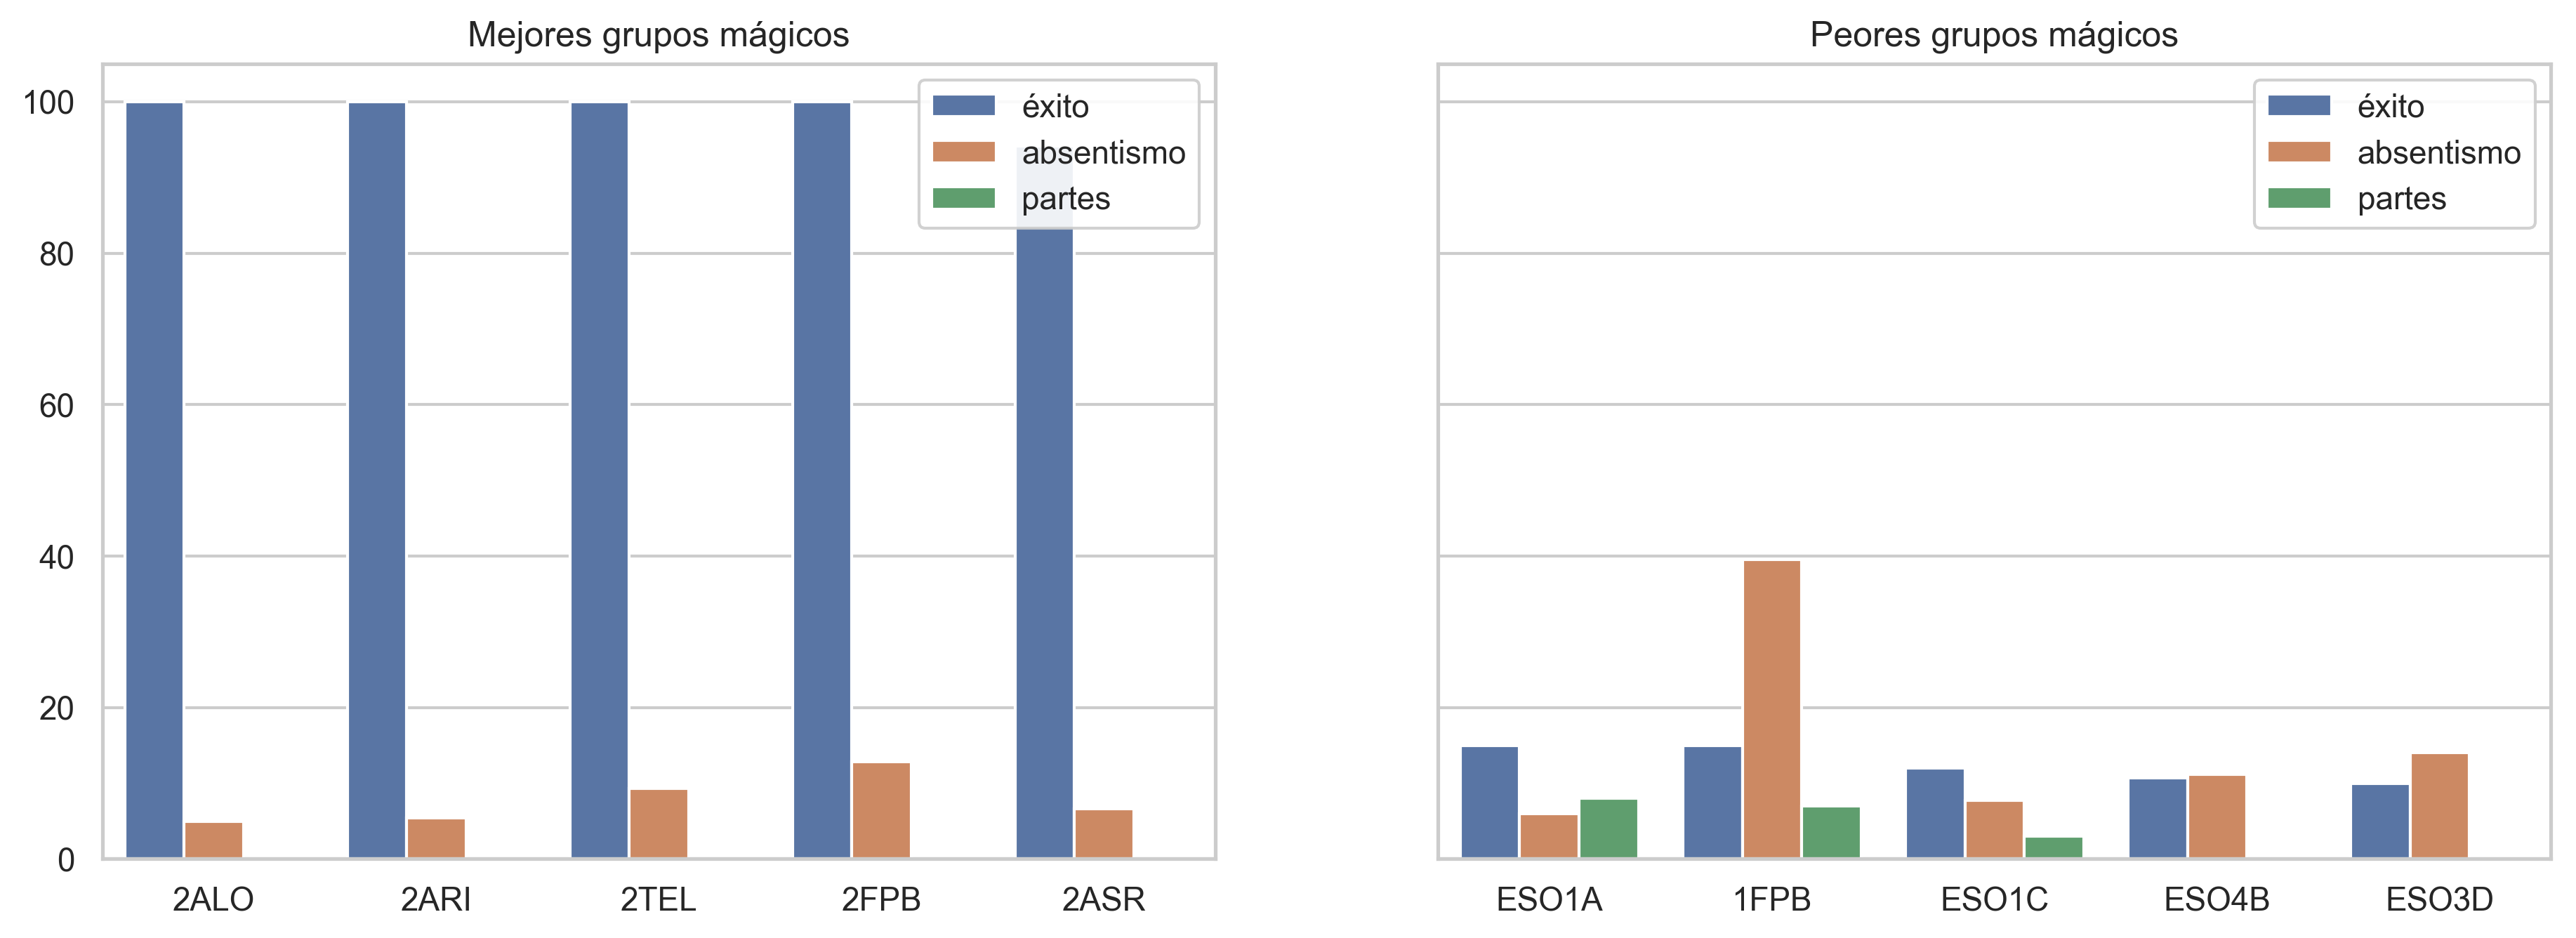

In [79]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True, dpi=FIGURE_DPI)

best_magic = pd.melt(magic.head(5).reset_index(), id_vars="grupo", value_vars=[
                     "éxito", "absentismo", "partes"])
g = sns.factorplot(x="grupo", y="value", hue="variable",
                   data=best_magic, kind="bar", ax=ax1)
ax1.set_title("Mejores grupos mágicos")
ax1.set(ylabel="", xlabel="")
ax1.legend(loc="best", frameon=True, framealpha=0.9)
plt.close(g.fig)

worse_magic = pd.melt(magic.tail(5).reset_index(), id_vars="grupo", value_vars=[
                      "éxito", "absentismo", "partes"])
g = sns.catplot(x="grupo", y="value", hue="variable",
                   data=worse_magic, kind="bar", ax=ax2, legend_out=True)
ax2.set_title("Peores grupos mágicos")
ax2.set(ylabel="", xlabel="")
ax2.legend(loc="best", frameon=True, framealpha=0.9)
plt.close(g.fig)